## Important Note

Due to the current policy of SLURM schedulers to charge the full allocated time to the account fairshare (regardless of timeout), it is a good idea to refurbish the slurm scheduler to adopt a "take and hold" approach to O2 resources since you get penalized for time that you request but do not use making allocation of resources later in the day (after running one or two steps) more difficult.

The primary piece of code that would need to be written for a take and hold model would need to include the following:

- More sophisticated memory clearing of the dask_controller object (total memory clearing without a restart that leads to crashes) THIS FIRST 
- Rule-based adjustments of chunk sizes to limit per-node memory use to make sure a flat memory request can be made at cluster initialization

# Introduction

This notebook contains the entire `TrenchRipper` pipline, divided into simple steps. This pipline is ideal for Mother <br>Machine image data where cells possess fluorescent segmentation markers. Segmentation on phase or brightfield data <br>is being developed, but is still an experimental feature.

The steps in this pipeline are as follows:
1. Extracting your Mother Machine data (.nd2) into hdf5 format
2. Identifying and cropping individual trenches into kymographs
3. Segmenting cells with a fluorescent marker
4. Determining lineages and object properties

In each step, the user will dynamically specify parameters using a series of interactive diagnostics on their dataset. <br>Following this, a parameter file will be written to disk and then used to deploy a parallel computation on the <br>dataset, either locally or on a SLURM cluster.


This is intended as an end-to-end solution to analyzing Mother Machine data. As such, **it is not trivial to plug data <br>directly into intermediate steps**, as it will lack the correct formatting and associated metadata. A notable <br>exception to this is using another program to segment data. The library references binary segmentation masks using <br>only metadata derived from their associated kymographs. As such, it is possible to generate segmentations on these <br>kymographs elsewhere and place them into the segmentation data path to have `TrenchRipper` act on those <br>segmentations instead. More on this in the segmentation section...

#### Imports

Run this section to import all relavent packages and libraries used in this notebook. You must run this everytime you open a new python kernel.

In [1]:

import TrenchRipper.trenchripper as tr
import warnings

warnings.filterwarnings(action="once")

import matplotlib

matplotlib.rcParams["figure.figsize"] = [20, 10]
%load_ext autoreload
%autoreload 2


In [2]:
# addition of active memory manager
import dask
dask.config.set({'distributed.scheduler.active-memory-manager.start': True});
dask.config.set({'distributed.scheduler.worker-ttl': "5m"});
dask.config.set({'distributed.scheduler.allowed-failures': 100});
dask.config.set({
    "dataframe.shuffle.method": "tasks",  # disable P2P shuffle, use old method
})
dask_wd = "/home/nao5/new_scratch/nao5/dask"
print(dask.__version__) 

exp_dir =  "/n/scratch/users/n/nao5/251209_experiment/"

2025.10.0


# Part 1: Growth/Division

#### Specify Paths

Begin by defining the directory in which all processing will be done, as well as the initial nd2 file we will be <br>processing. This line should be run everytime you open a new python kernel.

The format should be: `headpath = "/path/to/folder"` and `nd2file = "/path/to/file.nd2"`

For example:
```
headpath = "/n/scratch2/de64/2019-05-31_validation_data"
nd2file = "/n/scratch2/de64/2019-05-31_validation_data/Main_Experiment.nd2"
```

Ideally, these files should be placed in a storage location with relatively fast I/O

In [3]:
headpath = exp_dir + "Growth_Division"
nd2file = exp_dir + "251209_LIB613.nd2"



## Extract to hdf5 files

In this section, we will be extracting our image data. Currently this notebook only supports `.nd2` format; however <br>there are `.tiff` extractors in the TrenchRipper source files that are being added to `Master.ipynb` soon.

In the abstract, this step will take a single `.nd2` file and split it into a set of `.hdf5` files stored in <br>`headpath/hdf5`. Splitting the file up in this way will facilitate quick procesing in later steps. Each field of <br>view will be split into one or more `.hdf5` files, depending on the number of images per file requested (more on <br>this later). 

To keep track of which output files correspond to which FOVs, as well as to keep track of experiment metadata, the <br>extractor also outputs a `metadata.hdf5` file in the `headpath` folder. The data from this step is accessible in <br>that `metadata.hdf5` file under the `global` key. If you would like to look at this metadata, you may use the <br>`tr.utils.pandas_hdf5_handler` to read from this file. Later steps will add additional metadata under different <br>keys into the `metadata.hdf5` file.

#### Start Dask Workers

First, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

In [ ]:
# dask_controller = tr.trcluster.dask_controller(
#     walltime="1:00:00",
#     local=False,
#     n_workers=100,
#     n_workers_min=20,
#     memory="8GB",
#     working_directory=dask_wd,
# )
# dask_controller.startdask()

In [33]:
dask_controller = tr.trcluster.dask_controller(
    walltime="2:00:00",
    local=False,
    n_workers=200,
    n_workers_min=10,
    memory="12GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

110m
2:00:00


In [34]:
dask_controller.displaydashboard()

In [32]:
dask_controller.shutdown()

Done.


In [15]:
import os
import shutil
from dask.distributed import wait
import dask.dataframe as dd

# First, clean up the partial state
# Remove metadata_2 (partial write that failed)
if os.path.exists(kymoclust.kymographpath + "/metadata_2"):
    shutil.rmtree(kymoclust.kymographpath + "/metadata_2")
    print("Removed partial metadata_2")

# Remove remaining processed files
proc_files = [f for f in os.listdir(kymoclust.kymographpath) if f.startswith("kymograph_processed_")]
for f in proc_files:
    os.remove(kymoclust.kymographpath + "/" + f)
    print(f"Removed {f}")

# Now continue from the checkpoint
outputdf = dd.read_parquet(kymoclust.kymographpath + "/metadata")
outputdf = outputdf.persist()
wait(outputdf)
print(f"Loaded metadata: {outputdf.shape[0].compute()} rows")

# Check if global_rows.pkl processing is needed
if os.path.exists(kymoclust.kymographpath + "/global_rows.pkl"):
    print("Processing global_rows...")
    outputdf = outputdf.drop("row", axis=1)
    outputdf = outputdf.rename(columns={"new row": "row"})

# Checkpoint with write_metadata_file=False to avoid the bug
print("Writing checkpoint...")
dd.to_parquet(outputdf, kymoclust.kymographpath + "/metadata_2", engine='pyarrow', compression='gzip', write_metadata_file=False, schema="infer")
dask_controller.daskclient.cancel(outputdf)

# Swap files
shutil.rmtree(kymoclust.kymographpath + "/metadata")
os.rename(kymoclust.kymographpath + "/metadata_2", kymoclust.kymographpath + "/metadata")

# Read fresh (clears task graph)
outputdf = dd.read_parquet(kymoclust.kymographpath + "/metadata")
outputdf = outputdf.persist()
wait(outputdf)

# Continue with reindex_trenches and add_trenchids
print("Reindexing trenches...")
outputdf = kymoclust.reindex_trenches(outputdf).persist()
wait(outputdf)

print("Adding trenchids...")
outputdf = kymoclust.add_trenchids(outputdf).persist()
wait(outputdf)

# Add Trenchid Timepoint Index
print("Adding Trenchid Timepoint Index...")
outputdf["Trenchid Timepoint Index"] = outputdf.apply(
    lambda x: int(f'{x["trenchid"]:08n}{x["timepoints"]:04n}'), axis=1, meta=int
)
outputdf["Trenchid Timepoint Index"] = outputdf["Trenchid Timepoint Index"].astype(int)

# Drop FOV Parquet Index if it's a column
if "FOV Parquet Index" in outputdf.columns:
    outputdf = outputdf.drop(labels=["FOV Parquet Index"], axis=1)

# Final write
print("Writing final metadata...")
dd.to_parquet(outputdf, kymoclust.kymographpath + "/metadata_2", engine='pyarrow', compression='gzip', write_metadata_file=False, schema="infer")
dask_controller.daskclient.cancel(outputdf)

shutil.rmtree(kymoclust.kymographpath + "/metadata")
os.rename(kymoclust.kymographpath + "/metadata_2", kymoclust.kymographpath + "/metadata")

# Cleanup trenchiddf
if os.path.exists(kymoclust.kymographpath + "/trenchiddf"):
    shutil.rmtree(kymoclust.kymographpath + "/trenchiddf")

print("Done!")

Removed partial metadata_2
Removed kymograph_processed_500.hdf5
Removed kymograph_processed_501.hdf5
Removed kymograph_processed_502.hdf5
Removed kymograph_processed_503.hdf5
Loaded metadata: 168957540 rows
Writing checkpoint...
Reindexing trenches...
num_timepoints: 180
Unique (fov-row, trench) combinations: 938653


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 21.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 43.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Adding trenchids...


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/dataframe/dask_expr/_collection.py:3250: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))


[add_trenchids] Number of unique keys: 938653
[add_trenchids] Keys already sorted: False
[add_trenchids] First 10 keys (unsorted): [106, 10063, 10150, 10159, 100030154, 100040154, 200010123, 200050174, 300050082, 400040094]
[add_trenchids] First 10 keys (sorted):   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[add_trenchids] WARNING: Keys are NOT sorted! This would cause scrambled trenchids.
[add_trenchids] First mismatch at index 0: original=106, sorted=0
[add_trenchids] After sorting, first 10 keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.38 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Adding Trenchid Timepoint Index...
Writing final metadata...
Done!


In [14]:
import dask.dataframe as dd
from dask.distributed import wait
import numpy as np
import pandas as pd
import os
import shutil

# Read fresh
outputdf = dd.read_parquet(kymoclust.kymographpath + "/metadata")
print("Current columns:", outputdf.columns.tolist())

if "File Trench Index" not in outputdf.columns:
    print("\nFile Trench Index is missing - recreating with Dask operations")
    
    # Get the mapping info (this is small - just unique trenchids)
    num_tpts = len(outputdf["timepoints"].unique().compute().tolist())
    trenchid_list = sorted(outputdf["trenchid"].unique().compute().tolist())
    
    trench_timepoints_per_file = 10000  # Use whatever value you used originally
    trenches_per_file = trench_timepoints_per_file // num_tpts
    
    if len(trenchid_list) % trenches_per_file == 0:
        num_files = len(trenchid_list) // trenches_per_file
    else:
        num_files = (len(trenchid_list) // trenches_per_file) + 1
    
    print(f"num_tpts: {num_tpts}, trenches_per_file: {trenches_per_file}, num_files: {num_files}")
    print(f"Total unique trenchids: {len(trenchid_list)}")
    
    # Create a small lookup dataframe (one row per trenchid)
    trenchid_to_file_idx = {}
    trenchid_to_file_trench_idx = {}
    
    for i, tid in enumerate(trenchid_list):
        file_idx = i // trenches_per_file
        file_trench_idx = i % trenches_per_file
        trenchid_to_file_idx[tid] = file_idx
        trenchid_to_file_trench_idx[tid] = file_trench_idx
    
    # Create lookup table as a small pandas df, then merge
    lookup_df = pd.DataFrame({
        'trenchid': trenchid_list,
        'File Index': [trenchid_to_file_idx[t] for t in trenchid_list],
        'File Trench Index': [trenchid_to_file_trench_idx[t] for t in trenchid_list]
    })
    lookup_df['File Index'] = lookup_df['File Index'].astype(int)
    lookup_df['File Trench Index'] = lookup_df['File Trench Index'].astype(int)
    
    print(f"Lookup table size: {len(lookup_df)} rows")
    
    # Convert to dask (single partition since it's small)
    lookup_ddf = dd.from_pandas(lookup_df, npartitions=1)
    
    # Drop existing File Index if present (it might be wrong)
    if "File Index" in outputdf.columns:
        outputdf = outputdf.drop(columns=["File Index"])
    
    # Merge to add the new columns
    outputdf = outputdf.merge(lookup_ddf, on="trenchid", how="left")
    
    # Add File Parquet Index
    outputdf["File Parquet Index"] = outputdf.apply(
        lambda x: int(f'{int(x["File Index"]):08n}{int(x["File Trench Index"]):04n}{int(x["timepoints"]):04n}'),
        axis=1,
        meta=('File Parquet Index', int)
    )
    
    # Persist and wait
    outputdf = outputdf.persist()
    wait(outputdf)
    
    print("Columns after merge:", outputdf.columns.tolist())
    
    # Write out
    print("Writing to parquet...")
    dd.to_parquet(outputdf, kymoclust.kymographpath + "/metadata_2", engine='pyarrow', compression='gzip', write_metadata_file=False)
    dask_controller.daskclient.cancel(outputdf)
    
    if os.path.exists(kymoclust.kymographpath + "/metadata"):
        shutil.rmtree(kymoclust.kymographpath + "/metadata")
    os.rename(kymoclust.kymographpath + "/metadata_2", kymoclust.kymographpath + "/metadata")
    
    print("Done! Metadata updated with File Trench Index")
else:
    print("File Trench Index already exists")

Current columns: ['fov', 'row', 'trench', 'timepoints', 'File Index', 'Image Index', 'time (s)', 'lane orientation', 'y (local)', 'x (local)', 'y (global)', 'x (global)', 'Global Row', 'trenchid', 'Trenchid Timepoint Index']

File Trench Index is missing - recreating with Dask operations
num_tpts: 180, trenches_per_file: 55, num_files: 17067
Total unique trenchids: 938653
Lookup table size: 938653 rows


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 22.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Columns after merge: ['fov', 'row', 'trench', 'timepoints', 'Image Index', 'time (s)', 'lane orientation', 'y (local)', 'x (local)', 'y (global)', 'x (global)', 'Global Row', 'trenchid', 'Trenchid Timepoint Index', 'File Index', 'File Trench Index', 'File Parquet Index']
Writing to parquet...
Done! Metadata updated with File Trench Index


After running the above line, you will have a running Dask client. Run the line below and click the link to supervise <br>the computation being administered by the scheduler. 

Don't be alarmed if the screen starts mostly blank, it may take time for your workers to spin up. If you get a 404 <br>error on a cluster, it is likely that your ports are not being forwarded properly. If this occurs, please register <br>the issue on github.

##### Perform Extraction

Now that we have our cluster scheduler spun up, it is time to convert files. This will be handled by the <br>`hdf5_extractor` object. This extractor will pull up each FOV and split it such that each derived `.hdf5` file <br>contains, at maximum, N timepoints of that FOV per file. The image data stored in these files takes the <br>form of `(N,Y,X)` arrays that are accessible using the desired channel name as a key. 

The arguments for this extractor are:

 - **nd2file** : The filepath to the `.nd2` file you intend to extract.
 
 - **headpath** : The folder in which processing is occuring. Should be the same for each step in the pipeline.

 - **tpts_per_file** : The maximum number of timepoints stored in each output `.hdf5` file. Typical values are between 25 <br>and 100.

 - **ignore_fovmetadata** : Used when `.nd2` data is corrupted and does not possess records for stage positions or <br>timepoints. Only set `False` if the extractor throws errors on metadata handling.

 - **nd2reader_override** : Overrides values in metadata recovered using the `nd2reader`. Currently set to <br>`{"z_levels":[],"z_coordinates":[]}` by default to correct a known issue where z coordinates are mistakenly <br>interpreted as a z stack. See the [nd2reader](https://rbnvrw.github.io/nd2reader/) documentation for more info.

In [6]:
hdf5_extractor = tr.ndextract.hdf5_fov_extractor(
    nd2file,
    headpath,
    tpts_per_file=50,
    ignore_fovmetadata=False,
    nd2reader_override={"z_levels": [], "z_coordinates": []},
)

##### Extraction Parameters

Here, you may set the time interval you want to extract. Useful for cropping data to the period exhibiting the dynamics of interest.

Optionally take notes to add to the `metadata.hdf5` file. Notes may also be taken directly in this notebook.

In [7]:
hdf5_extractor.inter_set_params()

/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


interactive(children=(SelectMultiple(description='fov_list', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

#### List of paths to flat fields

/n/scratch/users/n/nao5/flat_field/Ti7/processed_flatfield/mCherry_norm.tif
/n/scratch/users/n/nao5/flat_field/Ti7/processed_flatfield/YFP_norm.tif
/n/scratch/users/n/nao5/flat_field/Ti7/processed_flatfield/CFP_norm.tif
/n/scratch/users/n/nao5/flat_field/Ti7/processed_flatfield/dark.tif


In [8]:
hdf5_extractor.inter_set_flatfieldpaths()

##### Begin Extraction 

Running the following line will start the extraction process. This may be monitored by examining the `Dask Dashboard` <br> under the link displayed earlier. Once the computation is complete, move to the next line.

This step may take a long time, though it is possible to speed it up using additional workers.

In [9]:
hdf5_extractor.extract(dask_controller)

/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


## Kymographs

Now that you have extracted your data into a series of `.hdf5` files, we will now perform identification and cropping <br>of the individual trenches/growth channels present in the images. This algorithm assumes that your growth trenches <br>are vertically aligned and that they alternate in their orientation from top to bottom. See the example image for the <br>correct geometry:

![example_image](./resources/example_image.jpg)

The output of this step will be a set of `.hdf5` files stored in `headpath/kymograph`. The image data stored in these <br>files takes the form of `(K,T,Y,X)` arrays where K is the trench index, T is time, and Y,X are the crop dimensions. <br>These arrays are accessible using keys of the form `"[Image Channel]"`. For example, looking up phase channel <br>data of trenches in the topmost row of an image will require the key `"Phase"`

### Test Parameters



#### Typical parameters for mCherry single channel imaging at 20x

- Y Percentile 95
- Y Foreground Percentile 65
- Y Smoothing Kernel 51
- Y Percentile Threshold 0.5
- Minimum Trench Length 50
- Midpoint Distance Tolerance 50
- Y Padding 20
- Trench Length 130
- Orientation Detection Method 1
- Expected Number of Rows (Manual Orientation Detection) 10
- Alternate Orientation True
- Alternate Orientation Over Rows? False
- Use Median Drift? True
- Consensus Orientations [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
- Consensus Midpoints [168.0, 411.5, 773.0, 1014.5, 1373.5, 1615.0, 1975.5, 2215.0, 2576.5, 2817.0]
- X Percentile 85
- X Background Kernel 51
- X Smoothing Kernel 5
- Otsu Threshold Scaling 0.0
- Minimum X Threshold 300
- Trench Width 20
- Trench Presence Threshold 0.8
- All Channels ['mCherry']
- Filter Channel None
- Invert False

##### Initialize the interactive kymograph class

As a first step, initialize the `tr.interactive.kymograph_interactive` class that will be help us choose the <br>parameters we will use to generate kymographs. 

In [10]:
interactive_kymograph = tr.kymograph_interactive(headpath)

/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [87]:
viewer = tr.hdf5_viewer(headpath,persist_data=False)

/n/scratch/users/n/nao5/251202_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


##### Examine Images

Here you can manually inspect images before beginning parameter tuning.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
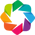

/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/holoviews/core/util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)

KeyboardInterrupt



In [12]:
viewer.view(width=1200,height=1200)

You will now want to select a few test FOVs to try out parameters on, the channel you want to detect trenches on, and <br>the time interval on which you will perform your processing.

The arguments for this step are:

- **seg_channel (string)** : The channel name that you would like to segment on.

- **invert (list)** : Whether or not you want to invert the image before detecting trenches. By default, it is assumed that <br>the trenches have a high pixel intensity relative to the background. This should be the case for Phase Contrast and <br>Fluorescence Imageing, but may not be the case for Brightfield Imaging, in which case you will want to invert the image.

- **fov_list (list)** : List of integers corresponding to the FOVs that you wish to make test kymographs of.

- **t_subsample_step (int)** : Step size to be used for subsampling input files in time, recommend that subsampling results in <br>between 5 and 10 timepoints for quick processing.

Hit the "Run Interact" button to lock in your parameters. The button will become transparent briefly and become solid again <br>when processing is complete. After that has occured, move on to the next step. 

In [11]:
#Set filter channel to None

interactive_kymograph.import_hdf5_interactive()

interactive(children=(Dropdown(description='seg_channel', options=('mCherry', 'CFP'), value='mCherry'), Dropdo…

##### Tune "trench-row" detection hyperparameters

The kymograph code begins by detecting the positions of trench rows in the image as follows:

1. Reducing each 2D image to a 1D signal along the y-axis by computing the qth percentile of the data along the x-axis
2. Smooth this signal using a median kernel
3. Normalize the signal by linearly scaling 0. and 1. to the minimum and maximum, respectively
4. Use a set threshold to determine the trench row poisitons

The arguments for this step are:

 - **y_percentile (int)** : Percentile to use for step 1.

 - **smoothing_kernel_y_dim_0 (int)** : Median kernel size to use for step 2.

 - **y_percentile_threshold (float)** : Threshold to use in step 4.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold <br>value for each fov will be displayed as a red line.

In [12]:
interactive_kymograph.preview_y_precentiles_interactive()

interactive(children=(IntSlider(value=95, description='y_percentile'), IntSlider(value=65, description='y_fore…

##### Tune "trench-row" cropping hyperparameters

Next, we will use the detected rows to perform cropping of the input image in the y-dimension:

1. Determine edges of trench rows based on threshold mask.
2. Filter out rows that are too small.
3. Use the remaining rows to compute the drift in y in each image.
4. Apply the drift to the initally detected rows to get rows in all timepoints.
5. Perform cropping using the "end" of the row as reference (the end referring to the part of the trench farthest from <br>the feeding channel).

Step 5 performs a simple algorithm to determine the orientation of each trench:

```
row_orientations = [] # A list of row orientations, starting from the topmost row
if the number of detected rows == 'Number of Rows': 
    row_orientations.append('Orientation')
elif the number of detected rows < 'Number of Rows':
    row_orientations.append('Orientation when < expected rows')
for row in rows:
    if row_orientations[-1] == downward:
        row_orientations.append(upward)
    elif row_orientations[-1] == upward:
        row_orientations.append(downward)
```

Additionally, if the device tranches face a single direction, alternation of row orientation may be turned off by setting the<br> `Alternate Orientation?` argument to False. The `Use Median Drift?` argument, when set to True, will use the<br> median drift in y across all FOVs for drift correction, instead of doing drift correction independently for all FOVs. <br>This can be useful if there are a large fraction of FOVs which are failing drift correction. Note that `Use Median Drift?` <br>sets this behavior for both y and x drift correction.

The arguments for this step are:

 - **y_min_edge_dist (int)** : Minimum row length necessary for detection (filters out small detected objects).

 - **padding_y (int)** : Padding to add to the end of trench row when cropping in the y-dimension.

 - **trench_len_y (int)** : Length from the end of each trench row to the feeding channel side of the crop.

 - **Number of Rows (int)** : The number of rows to expect in your image. For instance, two in the example image.
 
 - **Alternate Orientation? (bool)** : Whether or not to alternate the orientation of consecutive rows.

 - **Orientation (int)** : The orientation of the top-most row where 0 corresponds to a trench with a downward-oriented trench <br>opening and 1 corresponds to a trench with an upward-oriented trench opening.

 - **Orientation when < expected rows(int)** : The orientation of the top-most row when the number of detected rows is less than <br>expected. Useful if your trenches drift out of your image in some FOVs.
 
 - **Use Median Drift? (bool)** : Whether to use the median detected drift across all FOVs, instead of the drift detected in each FOV individually.

 - **images_per_row(int)** : How many images to output per row for this widget.

Running the following widget will display y-cropped images for each fov and timepoint.

In [13]:
interactive_kymograph.preview_y_precentiles_consensus_interactive()

interactive(children=(IntSlider(value=50, description='n_fovs', step=5), Dropdown(description='Y Consensus Ena…

In [14]:
interactive_kymograph.preview_y_crop_interactive()

interactive(children=(IntSlider(value=50, description='y_min_edge_dist', max=1000, min=5, step=5), IntSlider(v…

##### Tune trench detection hyperparameters

Next, we will detect the positions of trenchs in the y-cropped images as follows:

1. Reducing each 2D image to a 1D signal along the x-axis by computing the qth percentile of the data along the y-axis.
2. Determine the signal background by smoothing this signal using a large median kernel.
3. Subtract the background signal.
4. Smooth the resultant signal using a median kernel.
5. Use an [otsu threhsold](https://imagej.net/Auto_Threshold#Otsu) to determine the trench midpoint poisitons.

After this, x-dimension drift correction of our detected midpoints will be performed as follows:

6. Begin at t=1
7. For $m \in \{midpoints(t)\}$ assign $n \in \{midpoints(t-1)\}$ to m if n is the closest midpoint to m at time $t-1$,<br>
points that are not the closest midpoint to any midpoints in m will not be mapped.
8. Compute the translation of each midpoint at time.
9. Take the average of this value as the x-dimension drift from time t-1 to t.

The arguments for this step are:

 - **t (int)** : Timepoint to examine the percentiles and threshold in.

 - **x_percentile (int)** : Percentile to use for step 1.

 - **background_kernel_x (int)** : Median kernel size to use for step 2.

 - **smoothing_kernel_x (int)** : Median kernel size to use for step 4.

 - **otsu_scaling (float)** : Scaling factor to apply to the threshold determined by Otsu's method.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold <br>value for each fov will be displayed as a red line. In addition, it will display the detected midpoints for each of your timepoints. <br>If there is too much sparsity, or discontinuity, your drift correction will not be accurate.

In [15]:
interactive_kymograph.preview_x_percentiles_interactive()

interactive(children=(IntSlider(value=0, description='t', max=8), IntSlider(value=85, description='x_percentil…

##### Tune trench cropping hyperparameters

Trench cropping simply uses the drift-corrected midpoints as a reference and crops out some fixed length around them <br>
to produce an output kymograph. **Note that the current implementation does not allow trench crops to overlap**. If your<br>
trench crops do overlap, the error will not be caught here, but will cause issues later in the pipeline. As such, try <br>
to crop your trenches as closely as possible. This issue will be fixed in a later update.

The arguments for this step are:

 - **trench_width_x (int)** : Trench width to use for cropping.

 - **trench_present_thr (float)** : Trenches that appear in less than this percent of FOVs will be eliminated from the dataset.<br>
If not removed, missing positions will be inferred from the image drift.

 - **Use Median Drift? (bool)** : Whether to use the median detected drift across all FOVs, instead of the drift detected in each FOV individually.


Running the following widget will display a random kymograph for each row in each fov and will also produce midpoint plots <br>showing retained midpoints

In [16]:
interactive_kymograph.preview_kymographs_interactive()

interactive(children=(IntSlider(value=20, description='trench_width_x', max=1000, min=2, step=2), FloatSlider(…

##### Export and save hyperparameters

Run the following line to register and display the parameters you have selected for kymograph creation.

In [17]:
interactive_kymograph.process_results()

Y Percentile 95
Y Foreground Percentile 65
Y Smoothing Kernel 51
Y Percentile Threshold 0.5
Minimum Trench Length 50
Midpoint Distance Tolerance 50
Y Padding 20
Trench Length 130
Orientation Detection Method 1
Expected Number of Rows (Manual Orientation Detection) 8
Alternate Orientation True
Alternate Orientation Over Rows? False
Use Median Drift? True
Consensus Orientations [1, 0, 1, 0, 1, 0, 1, 0]
Consensus Midpoints [179.0, 393.0, 736.0, 951.0, 1294.5, 1505.5, 1850.0, 2064.0]
X Percentile 85
X Background Kernel 51
X Smoothing Kernel 5
Otsu Threshold Scaling 0.0
Minimum X Threshold 150
Trench Width 14
Trench Presence Threshold 0.8
All Channels ['mCherry', 'CFP']
Filter Channel None
Invert False


If you are satisfied with the above parameters, run the following line to write these parameters to disk at `headpath/kymograph.par`<br>
This file will be used to perform kymograph creation in the next section.

In [18]:
interactive_kymograph.write_param_file()

### Generate Kymograph

##### Start Dask Workers

Again, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2 for kymograph creation. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

After running the above line, you will have a running Dask client. Run the line below and click the link to supervise <br>the computation being administered by the scheduler. 

Don't be alarmed if the screen starts mostly blank, it may take time for your workers to spin up. If you get a 404 <br>error on a cluster, it is likely that your ports are not being forwarded properly. If this occurs, please register <br>the issue on github.

##### Perform Kymograph Cropping

Now that we have our cluster scheduler spun up, we will extract kymographs using the parameters stored in `headpath/kymograph.par`. <br>
This will be handled by the `kymograph_cluster` object. This will detect trenches in all of the files present in `headpath/hdf5` that <br>
you created in the first step. It will then crop these trenches and place the crops in a series of `.hdf5` files in `headpath/kymograph`. <br>
These files will store image data in the form of `(K,T,Y,X)` arrays where K is the trench index, T is time and Y,X are the image dimensions <br>
of the crop.

The arguments for this step are:

 - **headpath** : The folder in which processing is occuring. Should be the same for each step in the pipeline.

 - **trenches_per_file** : The maximum number of trenches stored in each output `.hdf5` file. Typical values are between 25 <br>and 100.

 - **paramfile** : Set to true if you want to use parameters from `headpath/kymograph.par` Otherwise, you will have to specify <br>
 parameters as direct arguments to `kymograph_cluster`.

In [35]:
kymoclust = tr.kymograph.kymograph_cluster(
    headpath=headpath, paramfile=True
)

##### Begin Kymograph Cropping 

Running the following line will start the cropping process. This may be monitored by examining the `Dask Dashboard` <br>
under the link displayed earlier. Once the computation is complete, move to the next line.

**Do not move on until all tasks are displayed as 'in memory' in Dask.**

In [36]:
kymoclust.generate_kymographs(dask_controller)

/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
Task exception was never retrieved
future: <Task finished name='Task-3934671' coro=<Client._gather.<locals>.wait() done, defined at /home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:2384> exception=AllExit()>
Traceback (most recent call last):
  File "/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py", line 2393, in wait
    raise AllExit()
distributed.client.AllExit


get coords
coords done


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/node.py:251: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._v_objectid = self._g_open()
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/node.py:251: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._v_objectid = self._g_open()


adding trenchids


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/dataframe/dask_expr/_collection.py:3250: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))


[add_trenchids] Number of unique keys: 938653
[add_trenchids] Keys already sorted: False
[add_trenchids] First 10 keys (unsorted): [30003, 30059, 40197, 40224, 60181, 100020088, 100030071, 100040180, 100050038, 200070013]
[add_trenchids] First 10 keys (sorted):   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[add_trenchids] WARNING: Keys are NOT sorted! This would cause scrambled trenchids.
[add_trenchids] First mismatch at index 0: original=30003, sorted=0
[add_trenchids] After sorting, first 10 keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.41 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


compiling output dataframe
setting FOV Parquet Index
Repartitioning
Writing to parquet


/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/kymograph.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_tpt["Initial Global Row"] = row_indices
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/kymograph.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_tpt["Global Row"] = first_tpt.apply(lambda x: init_global_row_to_global_row[x["Initial Global Row"]], axis=1)
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserW

In [10]:
ff = tr.focus_filter(headpath)

In [11]:
ff.choose_filter_channel_inter()

interactive(children=(Dropdown(description='channel', options=(None,), value=None), Button(description='Run In…

In [ ]:
ff.plot_histograms(intensity_range=(0,1500))

In [13]:
ff.plot_focus_threshold_inter()

No Channel Selected


In [12]:
ff.write_param_file()

In [ ]:
lane_overlay_handle = tr.lane_overlay(headpath,persist_data=True)
overlay = lane_overlay_handle.view_overlay(size=2500,vmin=0,vmax=4000)

In [ ]:
overlay

In [ ]:
lane_overlay_handle.save_rows()

##### Post-process Images

After the above step, kymographs will have been created for each `.hdf5` input file. They will now need to be reorganized <br>
into a new set of files such that each file has, at most, `trenches_per_file` trenches in each file.

**Do not move on until all tasks are displayed as 'in memory' in Dask.**

In [37]:
kymoclust.post_process(dask_controller,trench_timepoints_per_file=25000)

Number of timepoints per trench: 180
Number of trenches per file: 138


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 2.52 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 2.52 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Checkpointing before reindex_trenches...
Running reindex_trenches...
num_timepoints: 180
Unique (fov-row, trench) combinations: 938653


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 21.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 43.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 43.05 MiB

Running add_trenchids...


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/dataframe/dask_expr/_collection.py:3250: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))


[add_trenchids] Number of unique keys: 938653
[add_trenchids] Keys already sorted: False
[add_trenchids] First 10 keys (unsorted): [106, 10063, 10150, 10159, 100030154, 100040154, 200010123, 200050174, 300050082, 400040094]
[add_trenchids] First 10 keys (sorted):   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[add_trenchids] WARNING: Keys are NOT sorted! This would cause scrambled trenchids.
[add_trenchids] First mismatch at index 0: original=106, sorted=0
[add_trenchids] After sorting, first 10 keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.40 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


post_process complete!


In [27]:
print("="*70)
print("CHECKING post_process FILE INDEX ASSIGNMENT")
print("="*70)
basepath = "/home/nao5/new_scratch/251202_experiment/"

# The post_process function assigns File Index based on position in outputdf
# If file_indices_dask_df doesn't align with outputdf, the wrong File Index
# gets assigned to each trench

# Let's check: for a given trenchid, is the File Index consistent 
# with the trench's position in the sorted order?

old_kymo_meta = dd.read_parquet(basepath + "Growth_Division_old/kymograph/metadata").compute()
new_kymo_meta = dd.read_parquet(basepath + "Growth_Division_new/kymograph/metadata").compute()

# Get unique trenches (one row per trench)
old_trenches = old_kymo_meta[old_kymo_meta['timepoints'] == 0][['trenchid', 'fov', 'row', 'trench', 'File Index', 'File Trench Index']].sort_values('trenchid')
new_trenches = new_kymo_meta[new_kymo_meta['timepoints'] == 0][['trenchid', 'fov', 'row', 'trench', 'File Index', 'File Trench Index']].sort_values('trenchid')

print(f"Old: {len(old_trenches)} trenches")
print(f"New: {len(new_trenches)} trenches")

# Check if trenchid ordering matches File Index ordering
# In a correct pipeline, trenchid N should have File Index = N // chunk_size

print("\n--- Checking trenchid -> File Index consistency ---")

# Infer chunk_size from old data
old_chunk_size = old_trenches.groupby('File Index')['trenchid'].count().mode().values[0]
print(f"Old chunk size: {old_chunk_size}")

new_chunk_size = new_trenches.groupby('File Index')['trenchid'].count().mode().values[0]
print(f"New chunk size: {new_chunk_size}")

# For old: trenchid N should be in File Index N // chunk_size
old_trenches['expected_file_idx'] = old_trenches['trenchid'] // old_chunk_size
old_file_match = (old_trenches['File Index'] == old_trenches['expected_file_idx']).sum()
print(f"\nOld: {old_file_match}/{len(old_trenches)} trenches have expected File Index")

# For new:
new_trenches['expected_file_idx'] = new_trenches['trenchid'] // new_chunk_size
new_file_match = (new_trenches['File Index'] == new_trenches['expected_file_idx']).sum()
print(f"New: {new_file_match}/{len(new_trenches)} trenches have expected File Index")

# Show examples where new doesn't match
if new_file_match < len(new_trenches):
    print("\nExamples where new File Index doesn't match expected:")
    mismatched = new_trenches[new_trenches['File Index'] != new_trenches['expected_file_idx']].head(10)
    print(mismatched[['trenchid', 'fov', 'File Index', 'expected_file_idx', 'File Trench Index']])

CHECKING post_process FILE INDEX ASSIGNMENT
Old: 40283 trenches
New: 40764 trenches

--- Checking trenchid -> File Index consistency ---
Old chunk size: 54
New chunk size: 54

Old: 40283/40283 trenches have expected File Index
New: 40764/40764 trenches have expected File Index


In [20]:

basepath = "/home/nao5/new_scratch/251202_experiment/"
import h5py
import numpy as np
import pandas as pd
import dask.dataframe as dd

print("="*70)
print("COORDINATE-BASED TRENCH MAPPING COMPARISON")
print("="*70)

# Load metadata
old_kymo_meta = dd.read_parquet(basepath + "Growth_Division_old/kymograph/metadata").compute()
new_kymo_meta = dd.read_parquet(basepath + "Growth_Division_new/kymograph/metadata").compute()

# Get first timepoint only (coordinates are the same across timepoints)
old_t0 = old_kymo_meta[old_kymo_meta['timepoints'] == 0].copy()
new_t0 = new_kymo_meta[new_kymo_meta['timepoints'] == 0].copy()

# For a specific file, compare what trench is at each File Trench Index
test_file_idx = 200

print(f"\n--- File Index {test_file_idx}: Coordinate Mapping ---")

old_file = old_t0[old_t0['File Index'] == test_file_idx].sort_values('File Trench Index')
new_file = new_t0[new_t0['File Index'] == test_file_idx].sort_values('File Trench Index')

print(f"Old: {len(old_file)} trenches, New: {len(new_file)} trenches")

print("\nFile Trench Index -> (x, y, fov, trenchid) mapping:")
print(f"{'FTI':<5} | {'Old (x, y, fov, tid)':<35} | {'New (x, y, fov, tid)':<35} | Match?")
print("-" * 90)

for fti in range(min(20, len(old_file))):  # First 20 trenches
    old_row = old_file[old_file['File Trench Index'] == fti]
    new_row = new_file[new_file['File Trench Index'] == fti]
    
    if len(old_row) > 0 and len(new_row) > 0:
        old_row = old_row.iloc[0]
        new_row = new_row.iloc[0]
        
        old_str = f"({old_row['x (local)']:.1f}, {old_row['y (local)']:.1f}, {int(old_row['fov'])}, {int(old_row['trenchid'])})"
        new_str = f"({new_row['x (local)']:.1f}, {new_row['y (local)']:.1f}, {int(new_row['fov'])}, {int(new_row['trenchid'])})"
        
        coord_match = (abs(old_row['x (local)'] - new_row['x (local)']) < 0.1 and 
                       abs(old_row['y (local)'] - new_row['y (local)']) < 0.1)
        
        print(f"{fti:<5} | {old_str:<35} | {new_str:<35} | {'✓' if coord_match else '✗'}")

# Now check: for the SAME coordinates, what File Trench Index is assigned?
print("\n\n--- Same Coordinates -> Different File Trench Index? ---")

# Round coordinates for matching
old_file['x_round'] = old_file['x (local)'].round(1)
old_file['y_round'] = old_file['y (local)'].round(1)
new_file['x_round'] = new_file['x (local)'].round(1)
new_file['y_round'] = new_file['y (local)'].round(1)

# Create coordinate key
old_file['coord_key'] = old_file.apply(lambda r: (r['fov'], r['x_round'], r['y_round']), axis=1)
new_file['coord_key'] = new_file.apply(lambda r: (r['fov'], r['x_round'], r['y_round']), axis=1)

# Build mapping: coord -> File Trench Index
old_coord_to_fti = dict(zip(old_file['coord_key'], old_file['File Trench Index']))
new_coord_to_fti = dict(zip(new_file['coord_key'], new_file['File Trench Index']))

# Compare
common_coords = set(old_coord_to_fti.keys()) & set(new_coord_to_fti.keys())
print(f"Common coordinate keys: {len(common_coords)}")

mismatches = []
for coord in common_coords:
    old_fti = old_coord_to_fti[coord]
    new_fti = new_coord_to_fti[coord]
    if old_fti != new_fti:
        mismatches.append((coord, old_fti, new_fti))

print(f"File Trench Index mismatches: {len(mismatches)} / {len(common_coords)}")

if mismatches:
    print("\nExample mismatches (same physical trench -> different File Trench Index):")
    print(f"{'Coord (fov, x, y)':<25} | {'Old FTI':<10} | {'New FTI':<10}")
    print("-" * 50)
    for coord, old_fti, new_fti in mismatches[:15]:
        print(f"{str(coord):<25} | {int(old_fti):<10} | {int(new_fti):<10}")

COORDINATE-BASED TRENCH MAPPING COMPARISON

--- File Index 200: Coordinate Mapping ---
Old: 54 trenches, New: 54 trenches

File Trench Index -> (x, y, fov, trenchid) mapping:
FTI   | Old (x, y, fov, tid)                | New (x, y, fov, tid)                | Match?
------------------------------------------------------------------------------------------
0     | (689.2, 46.3, 6, 10800)             | (689.2, 46.3, 6, 10800)             | ✓
1     | (692.6, 46.3, 6, 10801)             | (692.6, 46.3, 6, 10801)             | ✓
2     | (696.1, 46.3, 6, 10802)             | (696.1, 46.3, 6, 10802)             | ✓
3     | (699.3, 46.3, 6, 10803)             | (699.3, 46.3, 6, 10803)             | ✓
4     | (702.9, 46.3, 6, 10804)             | (702.9, 46.3, 6, 10804)             | ✓
5     | (706.4, 46.3, 6, 10805)             | (706.4, 46.3, 6, 10805)             | ✓
6     | (709.8, 46.3, 6, 10806)             | (709.8, 46.3, 6, 10806)             | ✓
7     | (713.2, 46.3, 6, 10807)          

In [26]:
import h5py
import numpy as np

print("="*70)
print("SOURCE FOV vs KYMOGRAPH COMPARISON")
print("="*70)

# Check if source FOV data is the same
old_hdf5_path = basepath + "Growth_Division_old/hdf5/"
new_hdf5_path = basepath + "Growth_Division_new/hdf5/"

# Compare source FOV files
fov_idx = 0
print(f"\n--- Source FOV {fov_idx} Comparison ---")

with h5py.File(old_hdf5_path + f"hdf5_{fov_idx}.hdf5", 'r') as old_fov, \
     h5py.File(new_hdf5_path + f"hdf5_{fov_idx}.hdf5", 'r') as new_fov:
    
    print(f"Old FOV keys: {list(old_fov.keys())}")
    print(f"New FOV keys: {list(new_fov.keys())}")
    
    for channel in ['YFP', 'CFP', 'mCherry']:
        if channel in old_fov and channel in new_fov:
            old_data = old_fov[channel][:]
            new_data = new_fov[channel][:]
            
            print(f"\n{channel}:")
            print(f"  Old shape: {old_data.shape}, New shape: {new_data.shape}")
            
            if old_data.shape == new_data.shape:
                is_equal = np.array_equal(old_data, new_data)
                print(f"  Data identical: {is_equal}")
                if not is_equal:
                    diff = np.abs(old_data.astype(float) - new_data.astype(float))
                    print(f"  Max difference: {diff.max()}")
                    print(f"  Mean difference: {diff.mean()}")

# If source FOVs are identical, the issue is in the cropping step
# Let's check the in_bounds computation
print("\n\n--- Checking Crop Boundaries (in_bounds) ---")

# We need to trace through the crop_x function
# The in_bounds determine which pixel regions get written to which File Trench Index

# Load kymograph metadata to get the x coordinates used for cropping
old_kymo_meta = dd.read_parquet(basepath + "Growth_Division_old/kymograph/metadata").compute()
new_kymo_meta = dd.read_parquet(basepath + "Growth_Division_new/kymograph/metadata").compute()

# For File Index 0, timepoint 0
old_f0_t0 = old_kymo_meta[(old_kymo_meta['File Index'] == 0) & (old_kymo_meta['timepoints'] == 0)].sort_values('File Trench Index')
new_f0_t0 = new_kymo_meta[(new_kymo_meta['File Index'] == 0) & (new_kymo_meta['timepoints'] == 0)].sort_values('File Trench Index')

print("\nFile Index 0, Timepoint 0 - x (local) coordinates (in microns):")
print(f"{'FTI':<5} | {'Old x (local)':<15} | {'New x (local)':<15} | Match?")
print("-" * 50)
for fti in range(min(10, len(old_f0_t0))):
    old_x = old_f0_t0[old_f0_t0['File Trench Index'] == fti]['x (local)'].values[0]
    new_x = new_f0_t0[new_f0_t0['File Trench Index'] == fti]['x (local)'].values[0]
    match = '✓' if abs(old_x - new_x) < 0.01 else '✗'
    print(f"{fti:<5} | {old_x:<15.2f} | {new_x:<15.2f} | {match}")

SOURCE FOV vs KYMOGRAPH COMPARISON

--- Source FOV 0 Comparison ---
Old FOV keys: ['CFP', 'YFP', 'mCherry']
New FOV keys: ['CFP', 'YFP', 'mCherry']

YFP:
  Old shape: (50, 2304, 4096), New shape: (50, 2304, 4096)
  Data identical: True

CFP:
  Old shape: (50, 2304, 4096), New shape: (50, 2304, 4096)
  Data identical: True

mCherry:
  Old shape: (50, 2304, 4096), New shape: (50, 2304, 4096)
  Data identical: True


--- Checking Crop Boundaries (in_bounds) ---

File Index 0, Timepoint 0 - x (local) coordinates (in microns):
FTI   | Old x (local)   | New x (local)   | Match?
--------------------------------------------------
0     | 3.55            | 3.55            | ✓
1     | 6.99            | 6.99            | ✓
2     | 10.43           | 10.43           | ✓
3     | 13.86           | 13.86           | ✓
4     | 17.53           | 17.53           | ✓
5     | 20.97           | 20.97           | ✓
6     | 24.41           | 24.41           | ✓
7     | 27.84           | 27.84           | ✓
8 

In [30]:
import h5py
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("="*70)
print("VISUAL KYMOGRAPH_PROCESSED COMPARISON")
print("="*70)
basepath = "/home/nao5/new_scratch/251202_experiment/"

# Load metadata
old_kymo_meta = dd.read_parquet(basepath + "Growth_Division_old/kymograph/metadata").compute()
new_kymo_meta = dd.read_parquet(basepath + "Growth_Division_new/kymograph/metadata").compute()

pixel_microns = tr.pandas_hdf5_handler(exp_dir + "Growth_Division_new/metadata.hdf5").\
                    read_df("global",read_metadata=True).metadata["pixel_microns"]
# Paths
old_kymo_path = basepath + "Growth_Division_old/kymograph/"
new_kymo_path = basepath + "Growth_Division_new/kymograph/"
old_hdf5_path = basepath + "Growth_Division_old/hdf5/"
new_hdf5_path = basepath + "Growth_Division_new/hdf5/"

def visualize_processed_comparison(fov, row, trench_in_row, timepoint=0, channel='mCherry'):
    """
    Visualize old vs new kymograph_processed for a given FOV/row/trench
    
    Note: kymograph_processed files are organized by File Index, and within each file
    by row/channel. The trench index within the file corresponds to the trench's
    position within that row.
    """
    
    # Find the metadata for this FOV/row/trench combination
    old_match = old_kymo_meta[(old_kymo_meta['fov'] == fov) & 
                               (old_kymo_meta['row'] == row) & 
                               (old_kymo_meta['trench'] == trench_in_row) &
                               (old_kymo_meta['timepoints'] == timepoint)]
    new_match = new_kymo_meta[(new_kymo_meta['fov'] == fov) & 
                               (new_kymo_meta['row'] == row) & 
                               (new_kymo_meta['trench'] == trench_in_row) &
                               (new_kymo_meta['timepoints'] == timepoint)]
    
    if len(old_match) == 0 or len(new_match) == 0:
        print(f"FOV {fov}, row {row}, trench {trench_in_row} not found in both datasets")
        return
    
    old_row = old_match.iloc[0]
    new_row = new_match.iloc[0]
    
    # Get file info - for processed files, we need the File Index that corresponds to this FOV
    # The processed files are named kymograph_processed_{file_idx}.hdf5
    # We need to find which file_idx contains this FOV's data
    
    # Get all file indices for this FOV
    old_fov_files = old_kymo_meta[(old_kymo_meta['fov'] == fov) & (old_kymo_meta['timepoints'] == 0)]['File Index'].unique()
    new_fov_files = new_kymo_meta[(new_kymo_meta['fov'] == fov) & (new_kymo_meta['timepoints'] == 0)]['File Index'].unique()
    
    # For processed files, there should be one per FOV (before post_process reorganizes)
    # Let's check what processed files exist
    import os
    old_processed = sorted([f for f in os.listdir(old_kymo_path) if f.startswith('kymograph_processed_')])
    new_processed = sorted([f for f in os.listdir(new_kymo_path) if f.startswith('kymograph_processed_')])
    
    # Extract file indices from processed files
    old_proc_indices = [int(f.replace('kymograph_processed_', '').replace('.hdf5', '')) for f in old_processed]
    new_proc_indices = [int(f.replace('kymograph_processed_', '').replace('.hdf5', '')) for f in new_processed]
    
    print(f"Old processed file indices: {old_proc_indices}")
    print(f"New processed file indices: {new_proc_indices}")
    
    # The processed file index should match the Image Index or a related FOV index
    # Let's try using the first processed file for now
    old_proc_file = old_processed[fov] if fov < len(old_processed) else old_processed[0]
    new_proc_file = new_processed[fov] if fov < len(new_processed) else new_processed[0]
    
    print(f"\nUsing old: {old_proc_file}, new: {new_proc_file}")
    
    old_x_local = old_row['x (local)']
    old_y_local = old_row['y (local)']
    new_x_local = new_row['x (local)']
    new_y_local = new_row['y (local)']
    
    old_x_pixel = int(old_x_local / pixel_microns)
    old_y_pixel = int(old_y_local / pixel_microns)
    new_x_pixel = int(new_x_local / pixel_microns)
    new_y_pixel = int(new_y_local / pixel_microns)
    
    print(f"FOV {fov}, Row {row}, Trench {trench_in_row}:")
    print(f"  Old: x={old_x_local:.1f}um ({old_x_pixel}px), y={old_y_local:.1f}um ({old_y_pixel}px)")
    print(f"  New: x={new_x_local:.1f}um ({new_x_pixel}px), y={new_y_local:.1f}um ({new_y_pixel}px)")
    
    # Load data
    with h5py.File(old_kymo_path + old_proc_file, 'r') as old_kymo_h5, \
         h5py.File(new_kymo_path + new_proc_file, 'r') as new_kymo_h5, \
         h5py.File(old_hdf5_path + f"hdf5_{fov}.hdf5", 'r') as old_fov_h5, \
         h5py.File(new_hdf5_path + f"hdf5_{fov}.hdf5", 'r') as new_fov_h5:
        
        # Print structure
        print(f"\nOld processed file structure:")
        old_kymo_h5.visititems(lambda name, obj: print(f"  {name}: {obj.shape}") if isinstance(obj, h5py.Dataset) else None)
        
        print(f"\nNew processed file structure:")
        new_kymo_h5.visititems(lambda name, obj: print(f"  {name}: {obj.shape}") if isinstance(obj, h5py.Dataset) else None)
        
        # Dataset key is "row/channel"
        dataset_key = f"{row}/{channel}"
        
        if dataset_key not in old_kymo_h5 or dataset_key not in new_kymo_h5:
            print(f"Dataset {dataset_key} not found")
            return
        
        # Get kymograph data for ALL timepoints (shape: trench, time, y, x)
        old_kymo_all = old_kymo_h5[dataset_key][:]  # (n_trenches, T, Y, X)
        new_kymo_all = new_kymo_h5[dataset_key][:]
        
        print(f"\nOld {dataset_key} shape: {old_kymo_all.shape}")
        print(f"New {dataset_key} shape: {new_kymo_all.shape}")
        
        # The trench_in_row should be the index within this dataset
        if trench_in_row >= old_kymo_all.shape[0] or trench_in_row >= new_kymo_all.shape[0]:
            print(f"Trench {trench_in_row} out of range")
            return
        
        old_kymo_trench = old_kymo_all[trench_in_row]  # (T, Y, X)
        new_kymo_trench = new_kymo_all[trench_in_row]
        
        n_timepoints, kymo_h, kymo_w = old_kymo_trench.shape
        
        # Concatenate timepoints horizontally
        old_kymo_concat = np.concatenate([old_kymo_trench[t] for t in range(n_timepoints)], axis=1)
        new_kymo_concat = np.concatenate([new_kymo_trench[t] for t in range(n_timepoints)], axis=1)
        
        # Get source FOV at first timepoint
        old_fov_data = old_fov_h5[channel][timepoint, :, :]
        new_fov_data = new_fov_h5[channel][timepoint, :, :]
        
        # Create figure
        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(4, 3, height_ratios=[1.5, 1, 1, 1], hspace=0.3, wspace=0.3)
        
        margin = 150
        
        # Old FOV zoomed
        ax_old_fov = fig.add_subplot(gs[0, 0])
        y_start = max(0, old_y_pixel - margin)
        y_end = min(old_fov_data.shape[0], old_y_pixel + kymo_h + margin)
        x_start = max(0, old_x_pixel - margin)
        x_end = min(old_fov_data.shape[1], old_x_pixel + margin)
        
        vmax = np.percentile(old_fov_data, 99)
        ax_old_fov.imshow(old_fov_data[y_start:y_end, x_start:x_end], cmap='gray', vmin=0, vmax=vmax,
                          extent=[x_start, x_end, y_end, y_start])
        rect = patches.Rectangle((old_x_pixel - kymo_w//2, old_y_pixel), kymo_w, kymo_h,
                                   linewidth=2, edgecolor='lime', facecolor='none')
        ax_old_fov.add_patch(rect)
        ax_old_fov.set_title(f'OLD FOV {fov} - {channel}')
        ax_old_fov.set_xlabel('x (pixels)')
        ax_old_fov.set_ylabel('y (pixels)')
        
        # New FOV zoomed
        ax_new_fov = fig.add_subplot(gs[0, 1])
        y_start = max(0, new_y_pixel - margin)
        y_end = min(new_fov_data.shape[0], new_y_pixel + kymo_h + margin)
        x_start = max(0, new_x_pixel - margin)
        x_end = min(new_fov_data.shape[1], new_x_pixel + margin)
        
        vmax = np.percentile(new_fov_data, 99)
        ax_new_fov.imshow(new_fov_data[y_start:y_end, x_start:x_end], cmap='gray', vmin=0, vmax=vmax,
                          extent=[x_start, x_end, y_end, y_start])
        rect = patches.Rectangle((new_x_pixel - kymo_w//2, new_y_pixel), kymo_w, kymo_h,
                                   linewidth=2, edgecolor='cyan', facecolor='none')
        ax_new_fov.add_patch(rect)
        ax_new_fov.set_title(f'NEW FOV {fov} - {channel}')
        ax_new_fov.set_xlabel('x (pixels)')
        ax_new_fov.set_ylabel('y (pixels)')
        
        # Info panel
        ax_info = fig.add_subplot(gs[0, 2])
        ax_info.axis('off')
        
        corr = np.corrcoef(old_kymo_concat.flatten(), new_kymo_concat.flatten())[0, 1]
        info_text = f"""FOV: {fov}, Row: {row}, Trench: {trench_in_row}
Channel: {channel}
Timepoints: {n_timepoints}

OLD Pipeline:
  x: {old_x_local:.2f} um ({old_x_pixel} px)
  y: {old_y_local:.2f} um ({old_y_pixel} px)
  File: {old_proc_file}
  
NEW Pipeline:
  x: {new_x_local:.2f} um ({new_x_pixel} px)
  y: {new_y_local:.2f} um ({new_y_pixel} px)
  File: {new_proc_file}

Kymo shape: {kymo_h} x {kymo_w} x {n_timepoints}
Old mean: {old_kymo_concat.mean():.1f}
New mean: {new_kymo_concat.mean():.1f}
Correlation: {corr:.4f}
"""
        ax_info.text(0.05, 0.95, info_text, transform=ax_info.transAxes, fontsize=9,
                     verticalalignment='top', fontfamily='monospace')
        
        # Old kymograph (concatenated)
        ax_old_kymo = fig.add_subplot(gs[1, :])
        vmax_kymo = np.percentile(np.concatenate([old_kymo_concat, new_kymo_concat]), 99)
        ax_old_kymo.imshow(old_kymo_concat, cmap='gray', aspect='auto', vmin=0, vmax=vmax_kymo)
        ax_old_kymo.set_title(f'OLD Kymograph (processed) - row {row}, trench {trench_in_row}')
        ax_old_kymo.set_ylabel('y')
        
        # New kymograph (concatenated)
        ax_new_kymo = fig.add_subplot(gs[2, :])
        ax_new_kymo.imshow(new_kymo_concat, cmap='gray', aspect='auto', vmin=0, vmax=vmax_kymo)
        ax_new_kymo.set_title(f'NEW Kymograph (processed) - row {row}, trench {trench_in_row}')
        ax_new_kymo.set_ylabel('y')
        
        # Difference
        ax_diff = fig.add_subplot(gs[3, :])
        diff = old_kymo_concat.astype(float) - new_kymo_concat.astype(float)
        vabs = max(abs(diff.min()), abs(diff.max()), 1)
        ax_diff.imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vabs, vmax=vabs)
        ax_diff.set_title(f'Difference (Old - New), max |diff| = {vabs:.1f}')
        ax_diff.set_ylabel('y')
        
        plt.suptitle(f'Kymograph Processed Comparison: FOV {fov}, Row {row}, Trench {trench_in_row}', fontsize=14, fontweight='bold')
        plt.savefig(f'/mnt/user-data/outputs/processed_comparison_fov{fov}_row{row}_trench{trench_in_row}.png', dpi=150, bbox_inches='tight')
        plt.show()

# Test with a few combinations
test_cases = [(0, 0, 0), (0, 0, 5), (0, 0, 10), (0, 1, 0)]

for fov, row, trench in test_cases:
    try:
        visualize_processed_comparison(fov, row, trench, timepoint=0, channel='mCherry')
    except Exception as e:
        print(f"Error with FOV {fov}, row {row}, trench {trench}: {e}")
        import traceback
        traceback.print_exc()

VISUAL KYMOGRAPH_PROCESSED COMPARISON
FOV 0, row 0, trench 0 not found in both datasets
FOV 0, row 0, trench 5 not found in both datasets
FOV 0, row 0, trench 10 not found in both datasets
FOV 0, row 1, trench 0 not found in both datasets


/n/scratch/users/n/nao5/251202_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


CHECKING KYMOGRAPH_PROCESSED STRUCTURE
Old processed files: ['kymograph_processed_0.hdf5', 'kymograph_processed_1.hdf5', 'kymograph_processed_10.hdf5', 'kymograph_processed_11.hdf5', 'kymograph_processed_2.hdf5', 'kymograph_processed_3.hdf5', 'kymograph_processed_4.hdf5', 'kymograph_processed_5.hdf5', 'kymograph_processed_6.hdf5', 'kymograph_processed_7.hdf5', 'kymograph_processed_8.hdf5', 'kymograph_processed_9.hdf5']
New processed files: ['kymograph_processed_0.hdf5', 'kymograph_processed_1.hdf5', 'kymograph_processed_10.hdf5', 'kymograph_processed_11.hdf5', 'kymograph_processed_2.hdf5', 'kymograph_processed_3.hdf5', 'kymograph_processed_4.hdf5', 'kymograph_processed_5.hdf5', 'kymograph_processed_6.hdf5', 'kymograph_processed_7.hdf5', 'kymograph_processed_8.hdf5', 'kymograph_processed_9.hdf5']

Old file: kymograph_processed_0.hdf5 (idx=0)
New file: kymograph_processed_0.hdf5 (idx=0)

Old file structure:
  Group '0':
    CFP: (253, 50, 150, 13)
    YFP: (253, 50, 150, 13)
    mCherry:

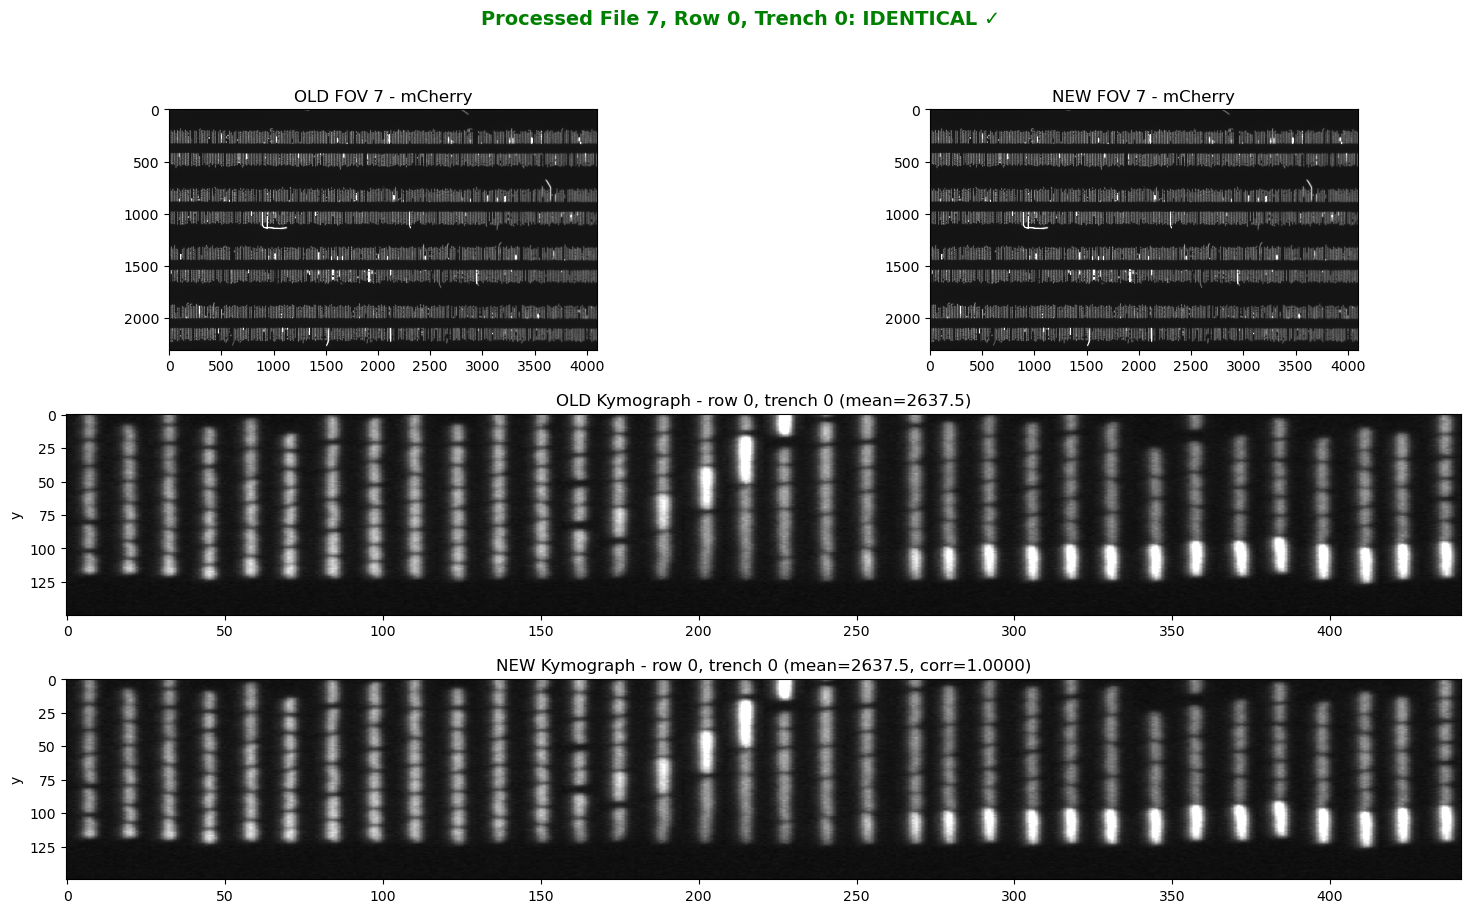

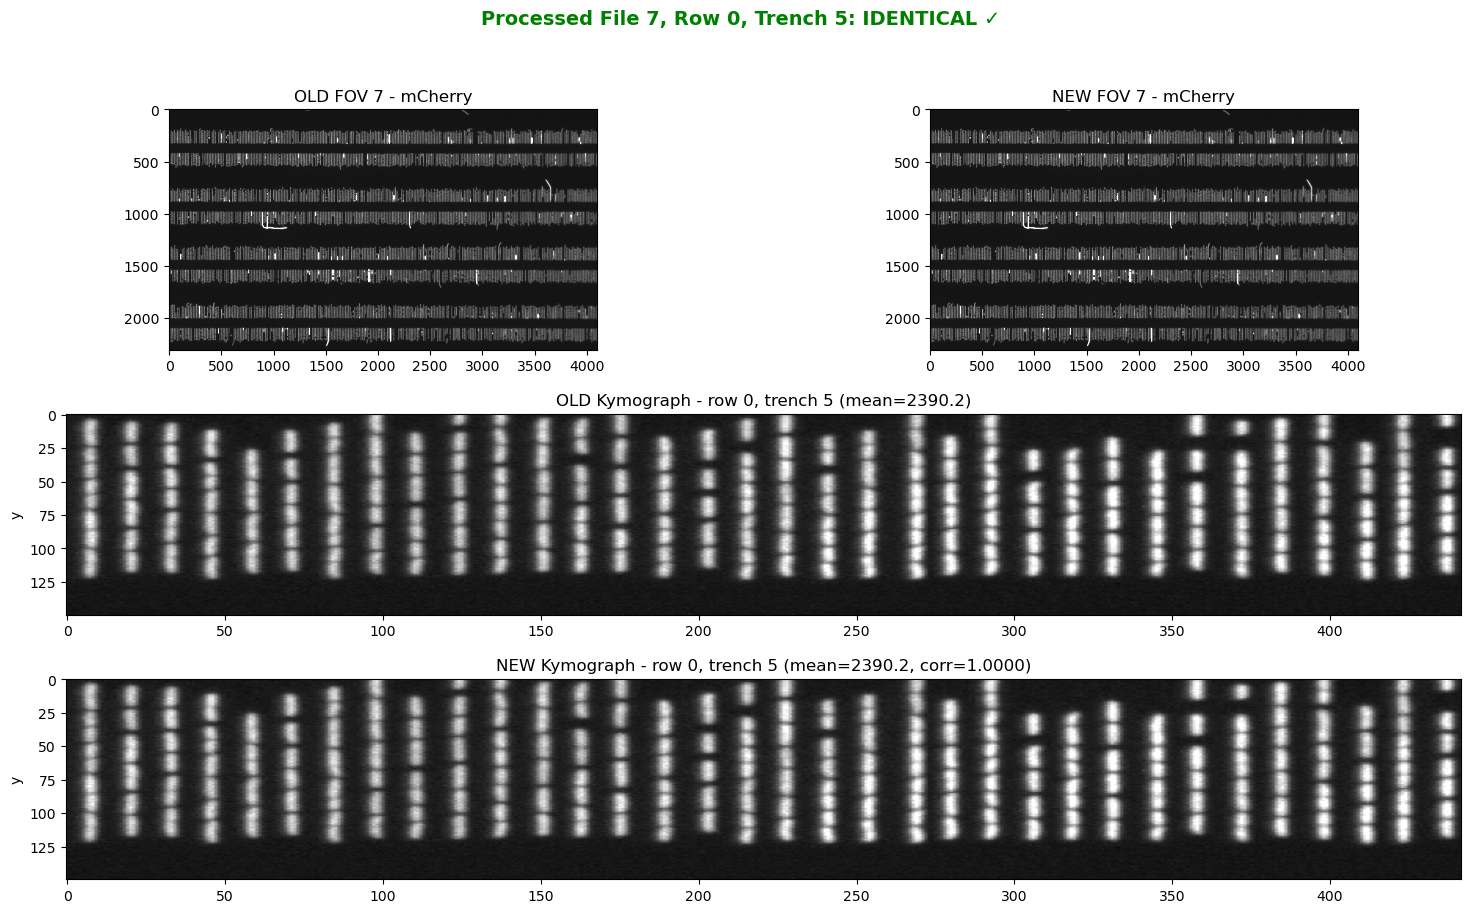

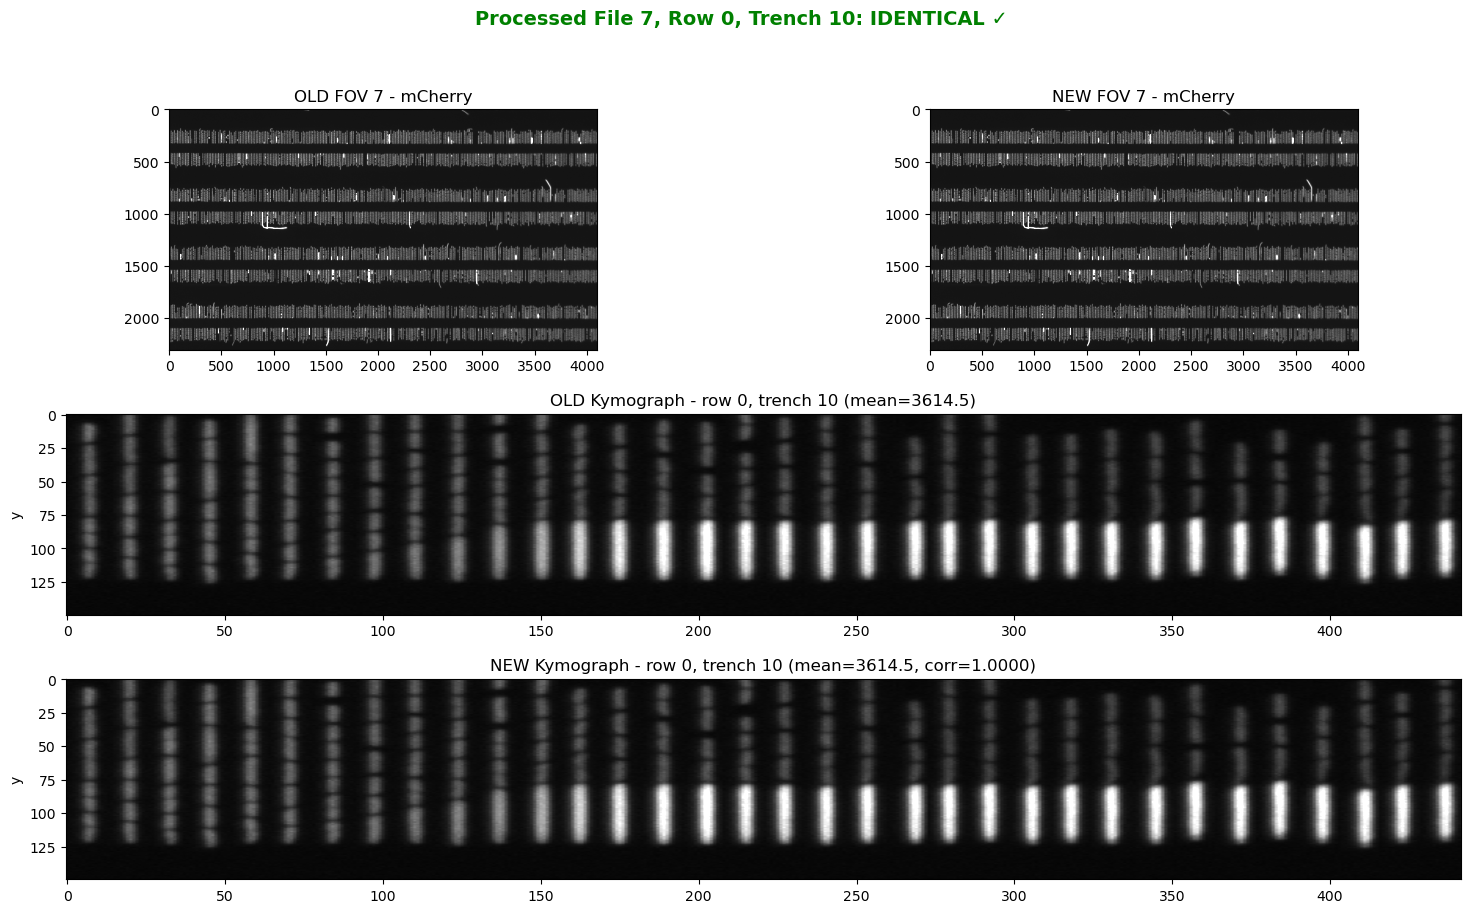

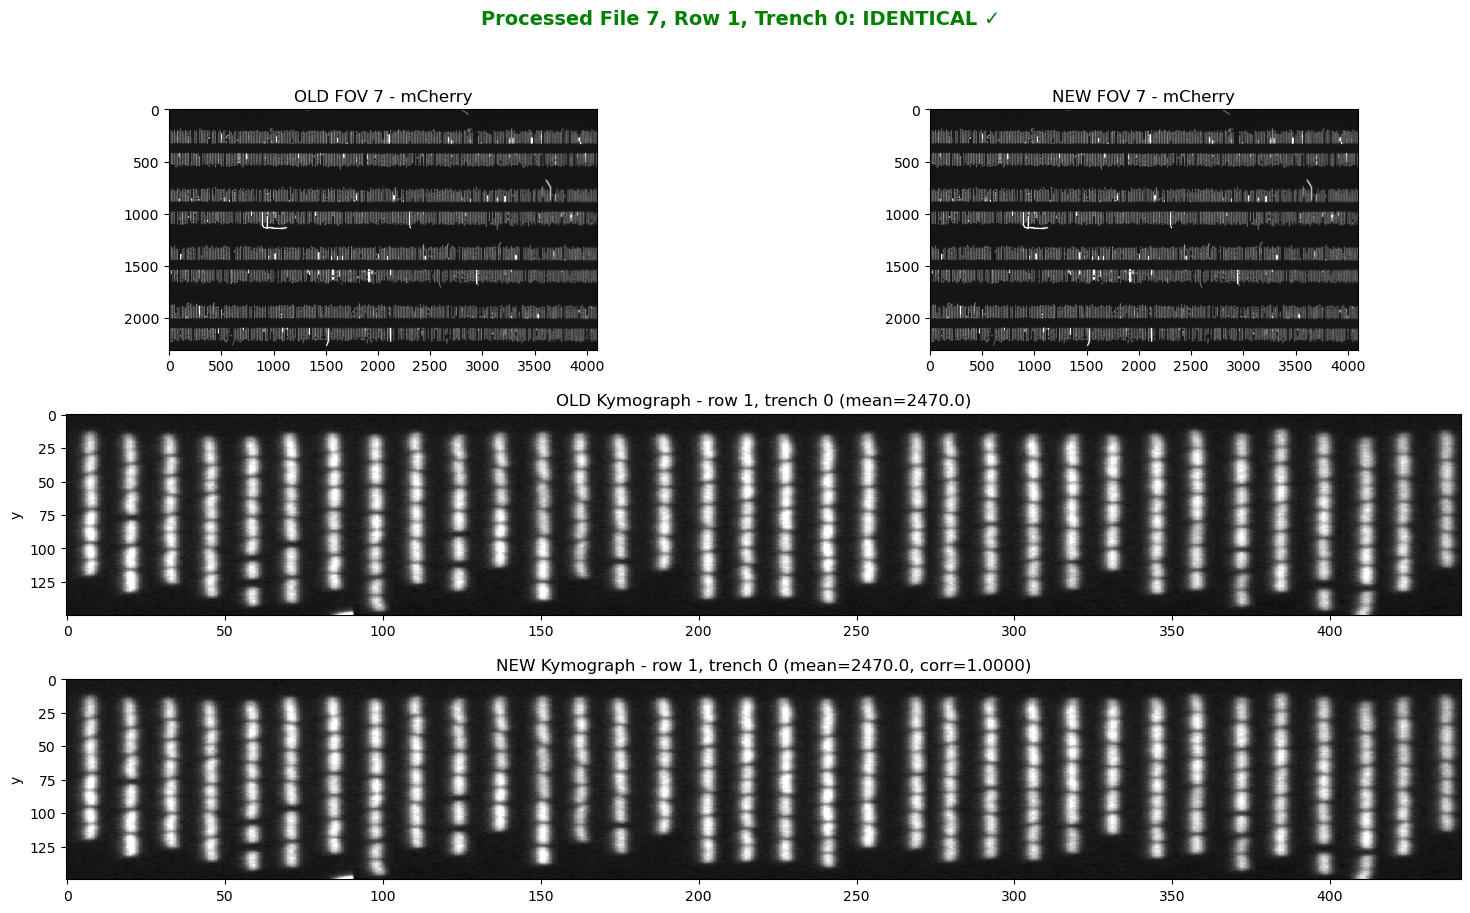

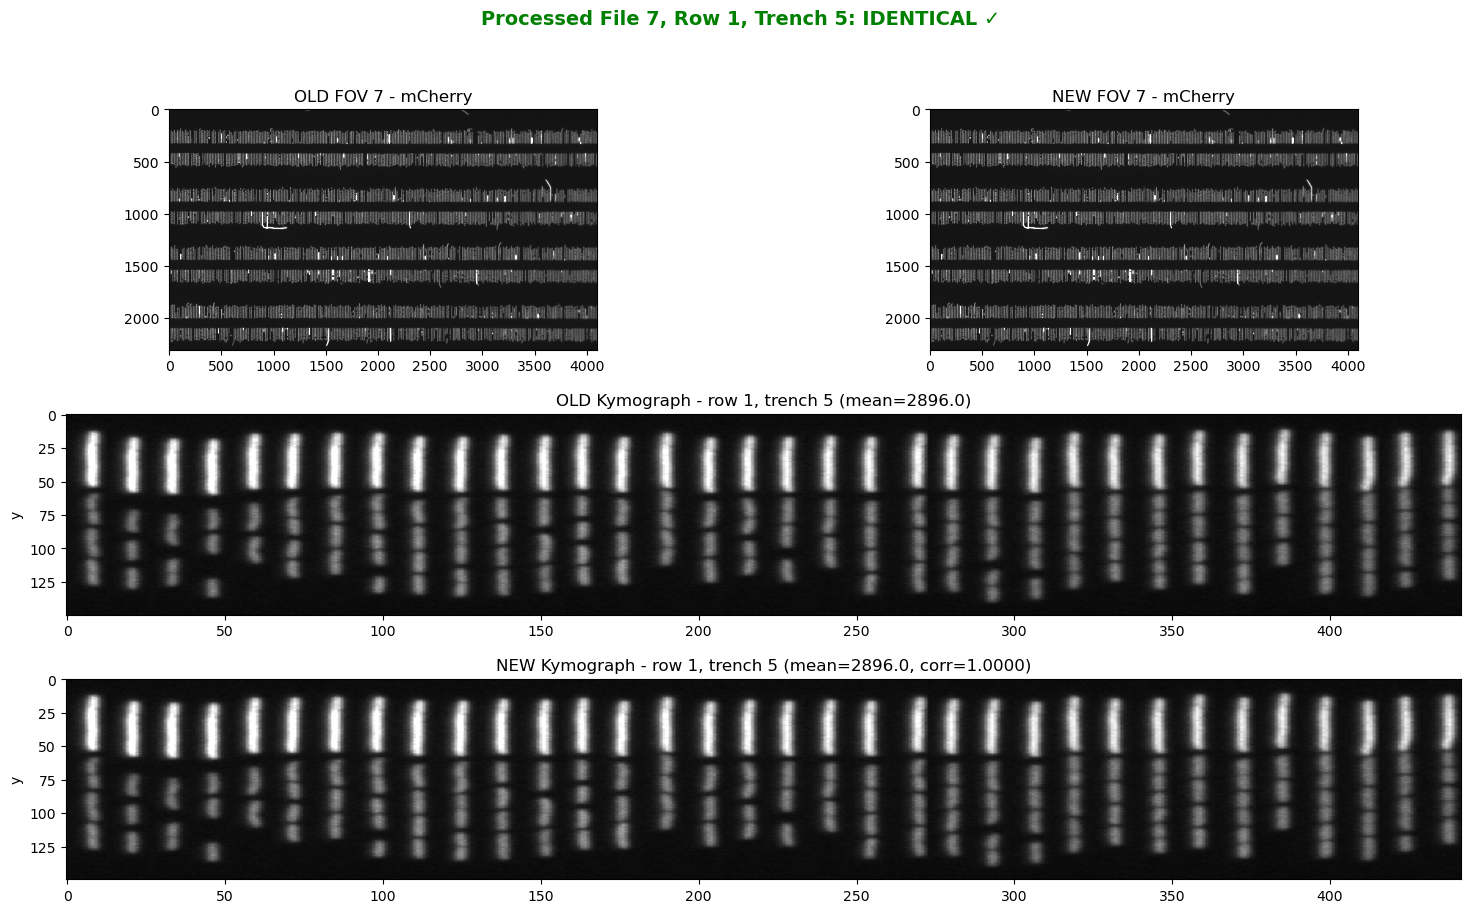

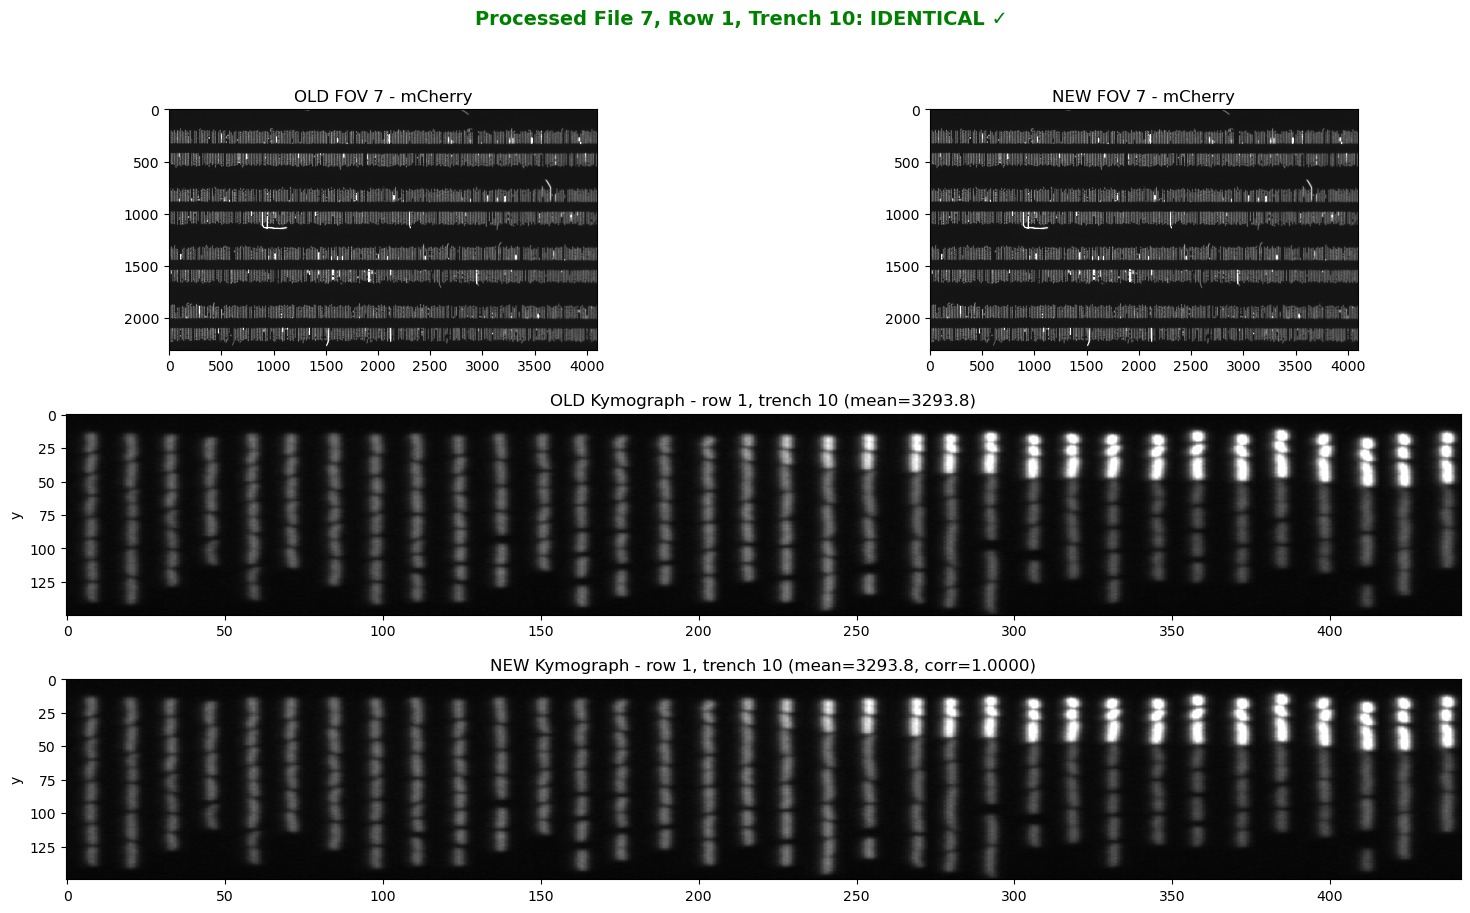

In [32]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("="*70)
print("CHECKING KYMOGRAPH_PROCESSED STRUCTURE")
print("="*70)

old_kymo_path = basepath + "Growth_Division_old/kymograph/"
new_kymo_path = basepath + "Growth_Division_new/kymograph/"
old_hdf5_path = basepath + "Growth_Division_old/hdf5/"
new_hdf5_path = basepath + "Growth_Division_new/hdf5/"

# List processed files
old_processed = sorted([f for f in os.listdir(old_kymo_path) if f.startswith('kymograph_processed_')])
new_processed = sorted([f for f in os.listdir(new_kymo_path) if f.startswith('kymograph_processed_')])

print(f"Old processed files: {old_processed}")
print(f"New processed files: {new_processed}")

# Check structure of first processed file
if old_processed and new_processed:
    old_file = old_processed[0]
    new_file = new_processed[0]
    
    # Extract file index
    old_file_idx = int(old_file.replace('kymograph_processed_', '').replace('.hdf5', ''))
    new_file_idx = int(new_file.replace('kymograph_processed_', '').replace('.hdf5', ''))
    
    print(f"\nOld file: {old_file} (idx={old_file_idx})")
    print(f"New file: {new_file} (idx={new_file_idx})")
    
    with h5py.File(old_kymo_path + old_file, 'r') as old_h5, \
         h5py.File(new_kymo_path + new_file, 'r') as new_h5:
        
        print(f"\nOld file structure:")
        for key in old_h5.keys():
            if isinstance(old_h5[key], h5py.Group):
                print(f"  Group '{key}':")
                for subkey in old_h5[key].keys():
                    print(f"    {subkey}: {old_h5[key][subkey].shape}")
            else:
                print(f"  {key}: {old_h5[key].shape}")
        
        print(f"\nNew file structure:")
        for key in new_h5.keys():
            if isinstance(new_h5[key], h5py.Group):
                print(f"  Group '{key}':")
                for subkey in new_h5[key].keys():
                    print(f"    {subkey}: {new_h5[key][subkey].shape}")
            else:
                print(f"  {key}: {new_h5[key].shape}")

# Now let's visualize directly from the processed files without relying on metadata
def visualize_processed_direct(file_idx, row, trench_idx, channel='mCherry'):
    """
    Directly compare kymograph_processed files
    """
    old_file = f"kymograph_processed_{file_idx}.hdf5"
    new_file = f"kymograph_processed_{file_idx}.hdf5"
    
    if not os.path.exists(old_kymo_path + old_file):
        print(f"Old file {old_file} not found")
        return
    if not os.path.exists(new_kymo_path + new_file):
        print(f"New file {new_file} not found")
        return
    
    with h5py.File(old_kymo_path + old_file, 'r') as old_h5, \
         h5py.File(new_kymo_path + new_file, 'r') as new_h5, \
         h5py.File(old_hdf5_path + f"hdf5_{file_idx}.hdf5", 'r') as old_fov_h5, \
         h5py.File(new_hdf5_path + f"hdf5_{file_idx}.hdf5", 'r') as new_fov_h5:
        
        dataset_key = f"{row}/{channel}"
        
        if dataset_key not in old_h5 or dataset_key not in new_h5:
            print(f"Dataset {dataset_key} not found in one of the files")
            print(f"  Old keys: {list(old_h5.keys())}")
            print(f"  New keys: {list(new_h5.keys())}")
            return
        
        old_kymo_all = old_h5[dataset_key][:]  # (n_trenches, T, Y, X)
        new_kymo_all = new_h5[dataset_key][:]
        
        print(f"\nFile {file_idx}, Row {row}, {channel}:")
        print(f"  Old shape: {old_kymo_all.shape}")
        print(f"  New shape: {new_kymo_all.shape}")
        
        if trench_idx >= old_kymo_all.shape[0]:
            print(f"  Trench {trench_idx} out of range (max={old_kymo_all.shape[0]-1})")
            return
        
        old_kymo_trench = old_kymo_all[trench_idx]  # (T, Y, X)
        new_kymo_trench = new_kymo_all[trench_idx]
        
        n_timepoints, kymo_h, kymo_w = old_kymo_trench.shape
        
        # Concatenate timepoints
        old_kymo_concat = np.concatenate([old_kymo_trench[t] for t in range(n_timepoints)], axis=1)
        new_kymo_concat = np.concatenate([new_kymo_trench[t] for t in range(n_timepoints)], axis=1)
        
        # Get FOV data
        old_fov_data = old_fov_h5[channel][0, :, :]  # First timepoint
        new_fov_data = new_fov_h5[channel][0, :, :]
        
        # Calculate correlation
        corr = np.corrcoef(old_kymo_concat.flatten(), new_kymo_concat.flatten())[0, 1]
        is_identical = np.array_equal(old_kymo_trench, new_kymo_trench)
        
        print(f"  Trench {trench_idx}: identical={is_identical}, corr={corr:.4f}")
        
        # Create figure
        fig = plt.figure(figsize=(18, 10))
        gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1, 1], hspace=0.3, wspace=0.2)
        
        # FOV images
        ax_old_fov = fig.add_subplot(gs[0, 0])
        vmax = np.percentile(old_fov_data, 99)
        ax_old_fov.imshow(old_fov_data, cmap='gray', vmin=0, vmax=vmax)
        ax_old_fov.set_title(f'OLD FOV {file_idx} - {channel}')
        
        ax_new_fov = fig.add_subplot(gs[0, 1])
        vmax = np.percentile(new_fov_data, 99)
        ax_new_fov.imshow(new_fov_data, cmap='gray', vmin=0, vmax=vmax)
        ax_new_fov.set_title(f'NEW FOV {file_idx} - {channel}')
        
        # Kymographs
        vmax_kymo = np.percentile(np.concatenate([old_kymo_concat, new_kymo_concat]), 99)
        
        ax_old_kymo = fig.add_subplot(gs[1, :])
        ax_old_kymo.imshow(old_kymo_concat, cmap='gray', aspect='auto', vmin=0, vmax=vmax_kymo)
        ax_old_kymo.set_title(f'OLD Kymograph - row {row}, trench {trench_idx} (mean={old_kymo_concat.mean():.1f})')
        ax_old_kymo.set_ylabel('y')
        
        ax_new_kymo = fig.add_subplot(gs[2, :])
        ax_new_kymo.imshow(new_kymo_concat, cmap='gray', aspect='auto', vmin=0, vmax=vmax_kymo)
        ax_new_kymo.set_title(f'NEW Kymograph - row {row}, trench {trench_idx} (mean={new_kymo_concat.mean():.1f}, corr={corr:.4f})')
        ax_new_kymo.set_ylabel('y')
        
        plt.suptitle(f'Processed File {file_idx}, Row {row}, Trench {trench_idx}: {"IDENTICAL ✓" if is_identical else "DIFFERENT ✗"}', 
                     fontsize=14, fontweight='bold', color='green' if is_identical else 'red')
        plt.savefig(f'/mnt/user-data/outputs/processed_f{file_idx}_r{row}_t{trench_idx}.png', dpi=150, bbox_inches='tight')
        plt.show()

# Test with available files
if old_processed:
    first_file_idx = int(old_processed[9].replace('kymograph_processed_', '').replace('.hdf5', ''))
    
    # Try a few combinations
    for row in [0, 1]:
        for trench in [0, 5, 10]:
            try:
                visualize_processed_direct(first_file_idx, row, trench, channel='mCherry')
            except Exception as e:
                print(f"Error: {e}")

In [ ]:
old_kymo = pd

VISUAL KYMOGRAPH COMPARISON


/n/scratch/users/n/nao5/251202_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


Using pixel_microns: 0.229156233018617

Trenchid 0:
  Old: FOV=9, File Index=0, FTI=0, x=5.6um, y=45.8um
  New: FOV=9, File Index=0, FTI=0, x=5.6um, y=45.8um
Error visualizing trenchid 0: [Errno 2] No such file or directory: '/mnt/user-data/outputs/trench_comparison_0.png'

Trenchid 10:
  Old: FOV=9, File Index=0, FTI=10, x=43.9um, y=45.8um
  New: FOV=9, File Index=0, FTI=10, x=43.9um, y=45.8um
Error visualizing trenchid 10: [Errno 2] No such file or directory: '/mnt/user-data/outputs/trench_comparison_10.png'

Trenchid 50:
  Old: FOV=9, File Index=0, FTI=50, x=195.6um, y=45.8um
  New: FOV=9, File Index=0, FTI=50, x=195.6um, y=45.8um
Error visualizing trenchid 50: [Errno 2] No such file or directory: '/mnt/user-data/outputs/trench_comparison_50.png'

Trenchid 100:
  Old: FOV=9, File Index=1, FTI=46, x=384.4um, y=45.8um
  New: FOV=9, File Index=1, FTI=46, x=384.4um, y=45.8um
Error visualizing trenchid 100: [Errno 2] No such file or directory: '/mnt/user-data/outputs/trench_comparison_10

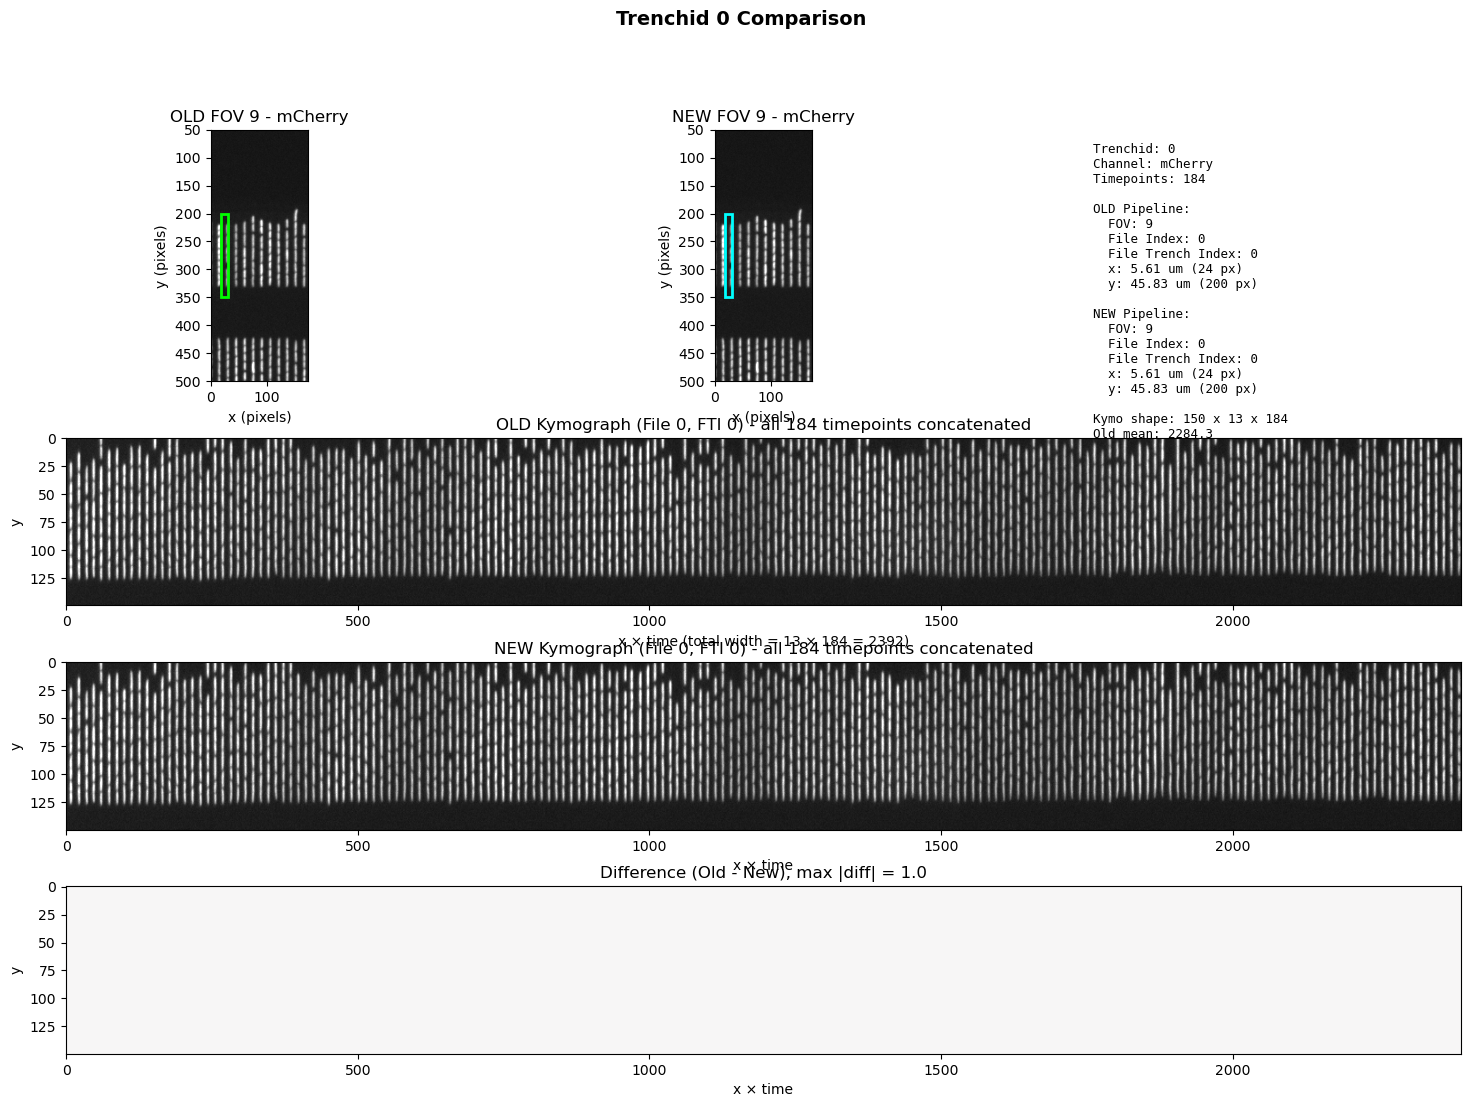

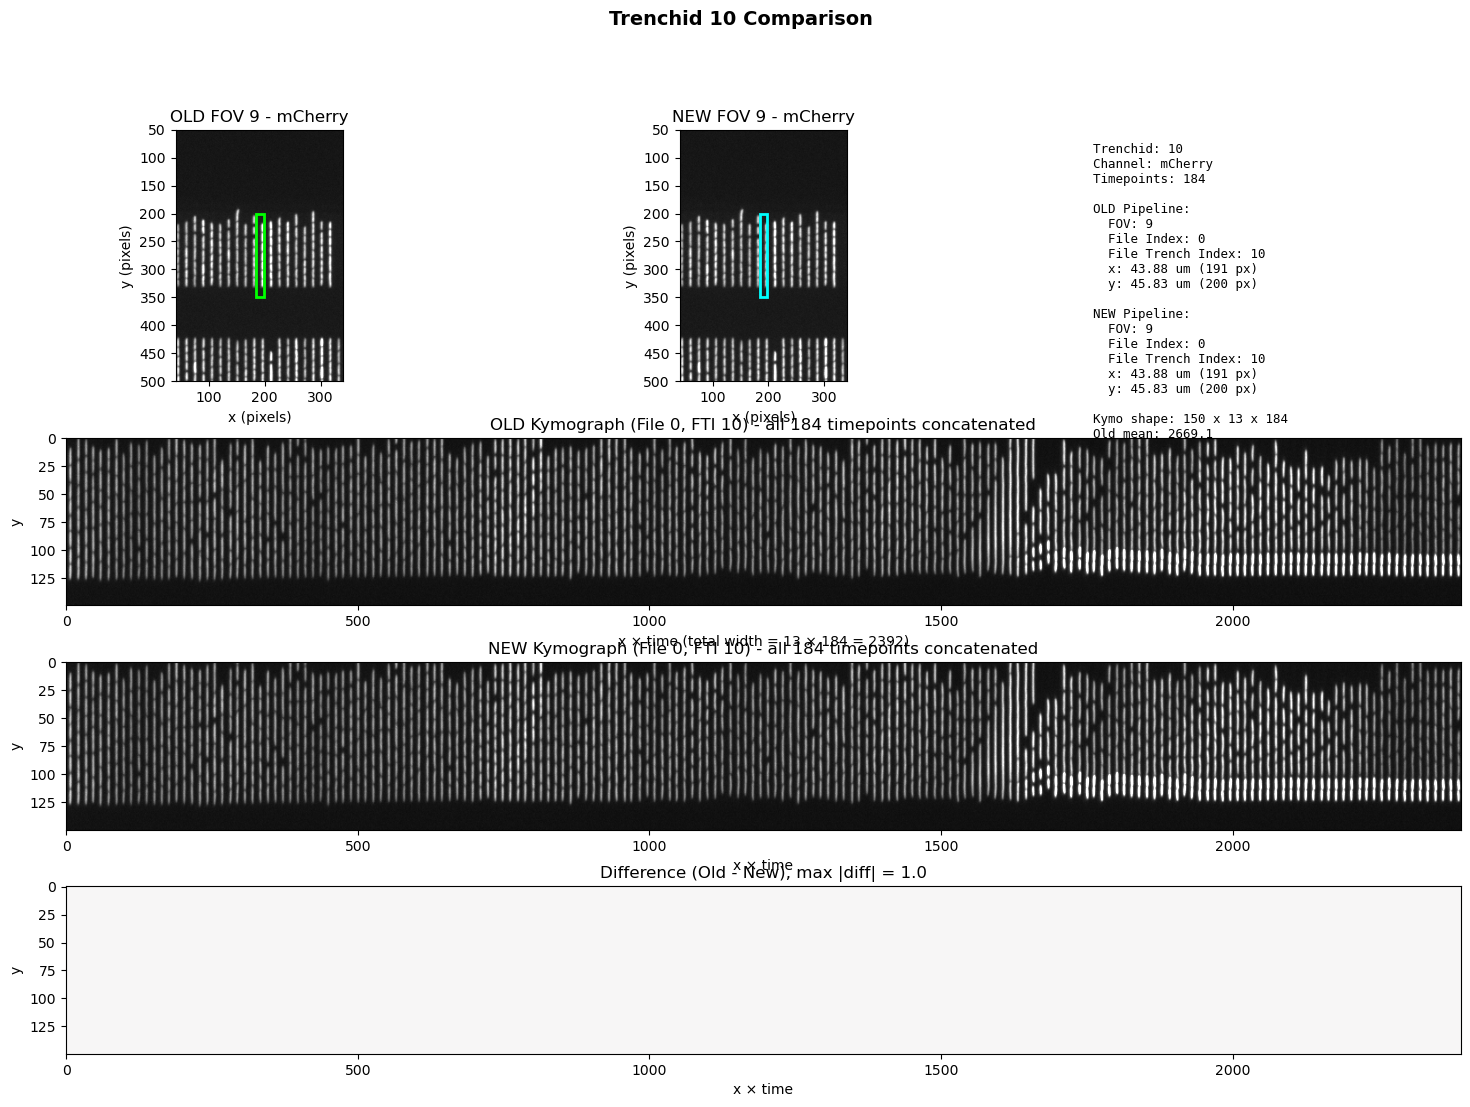

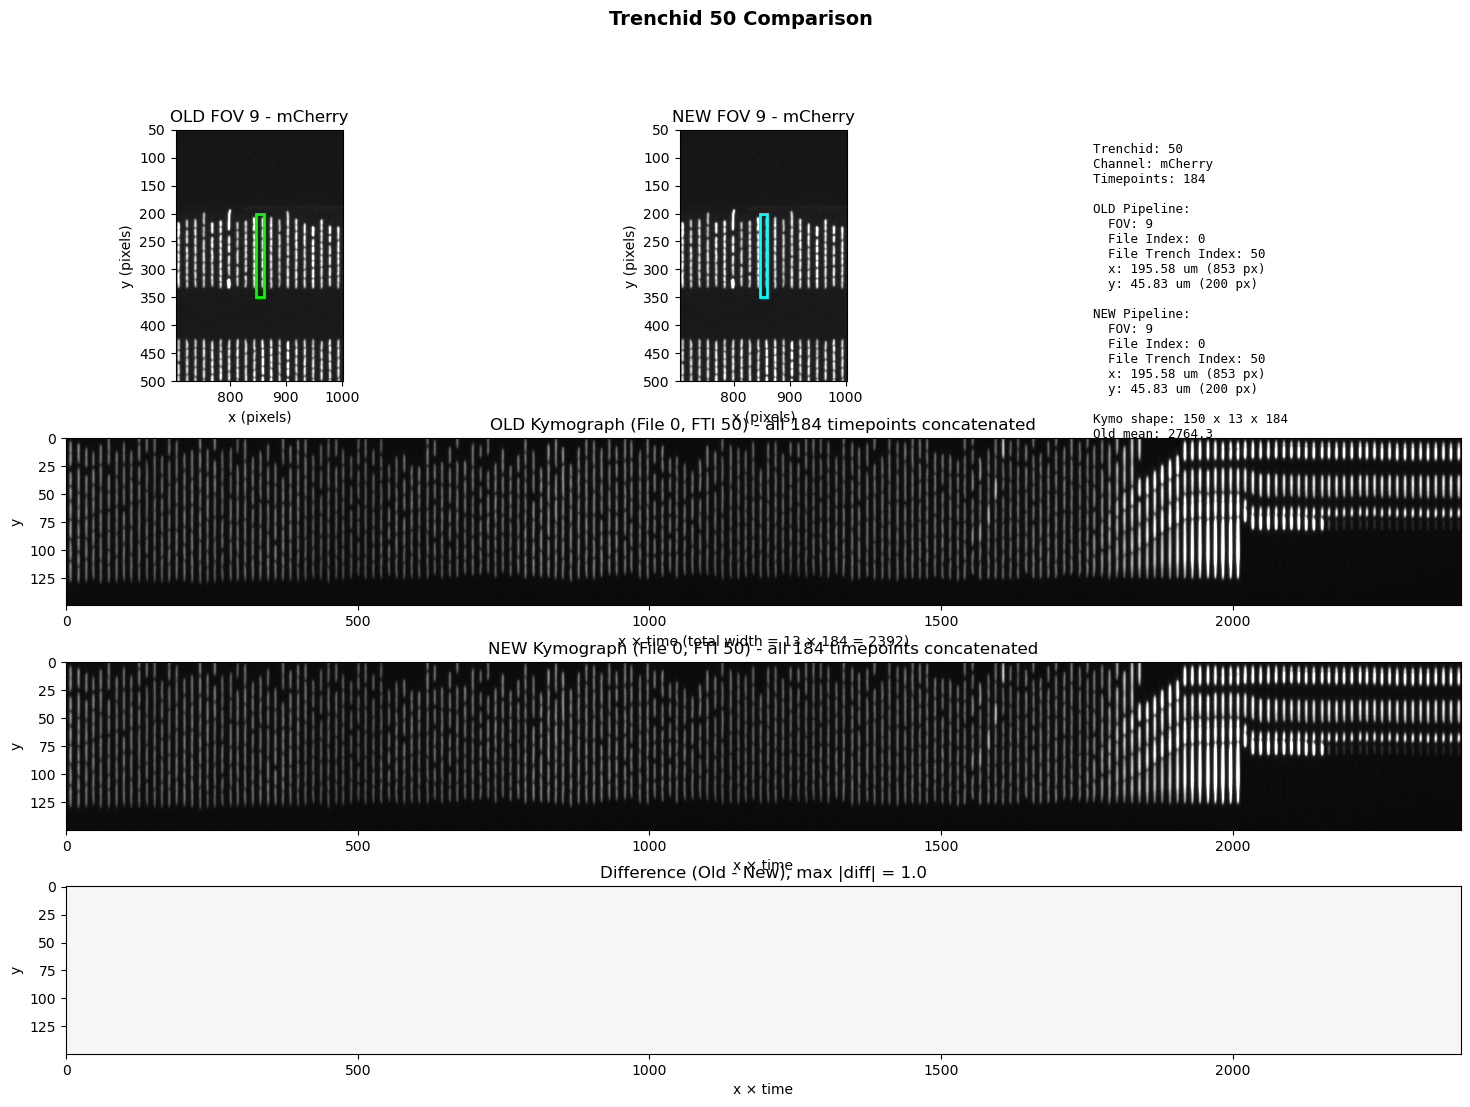

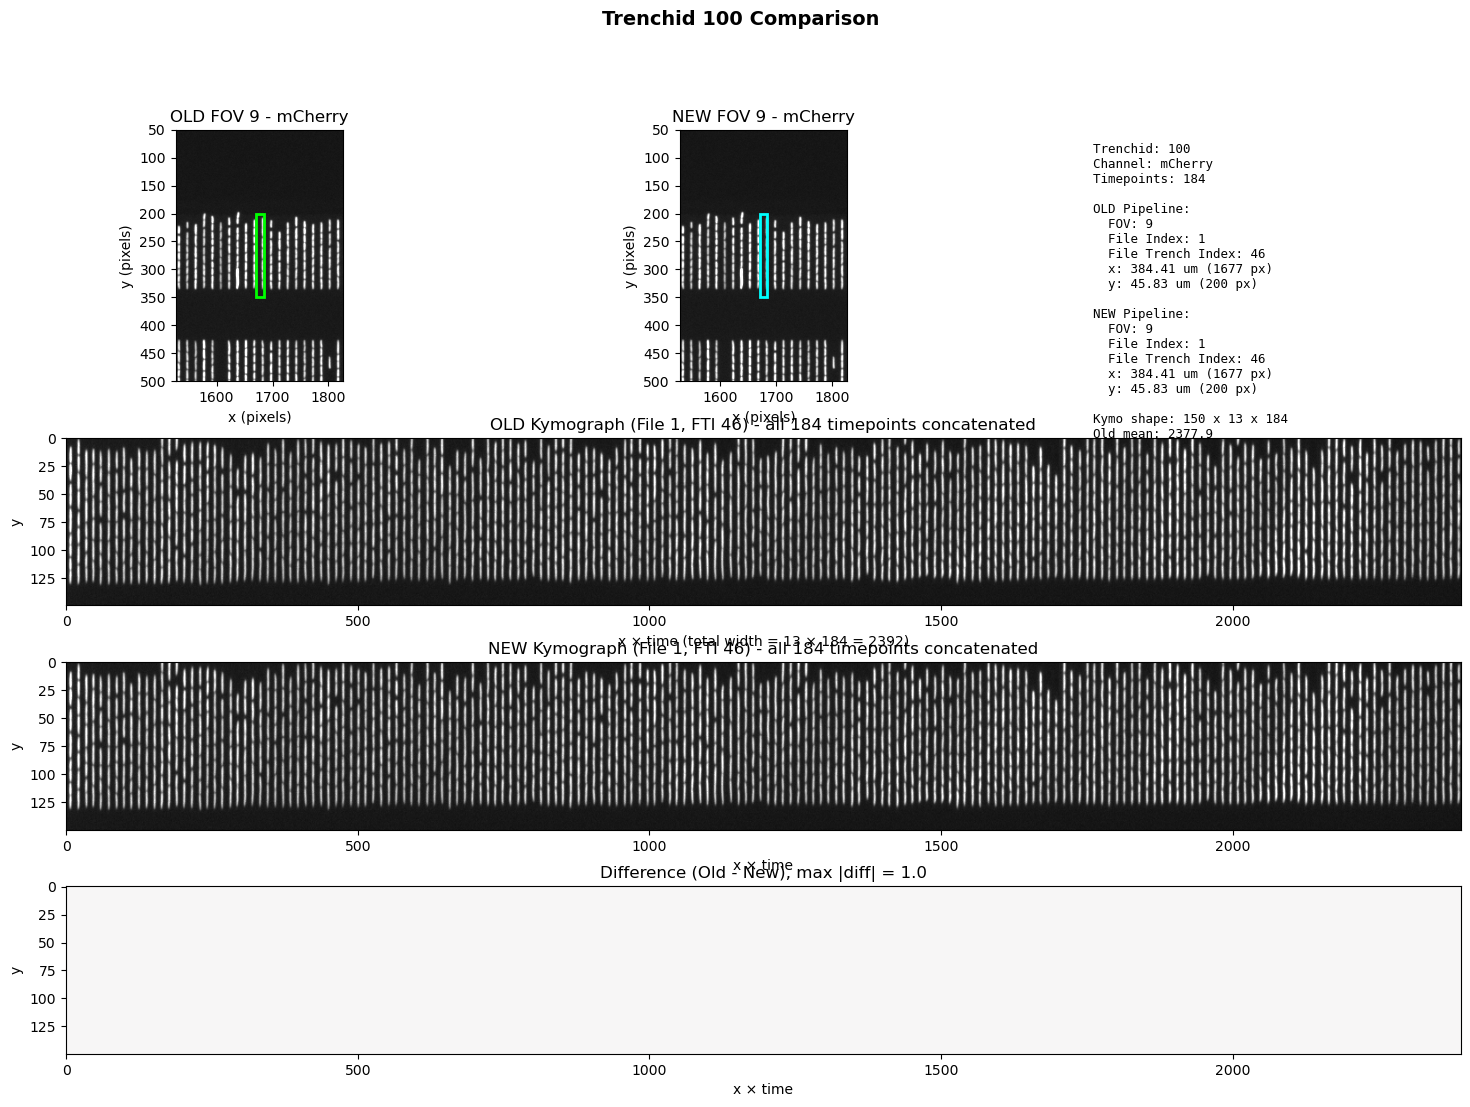

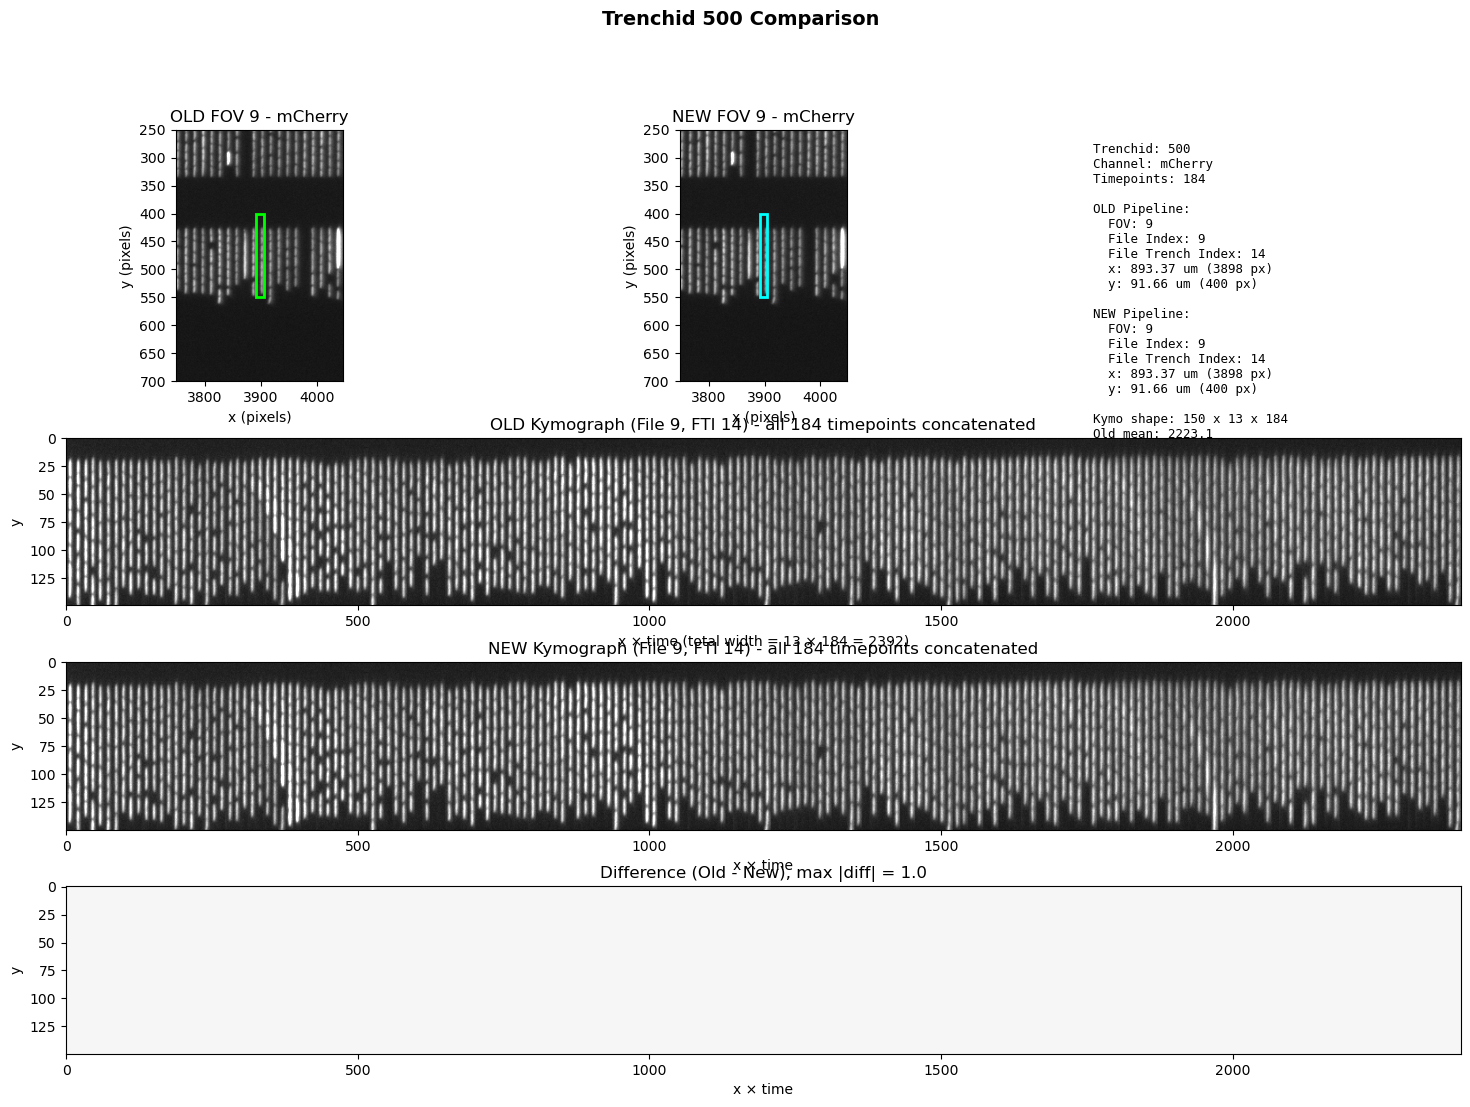

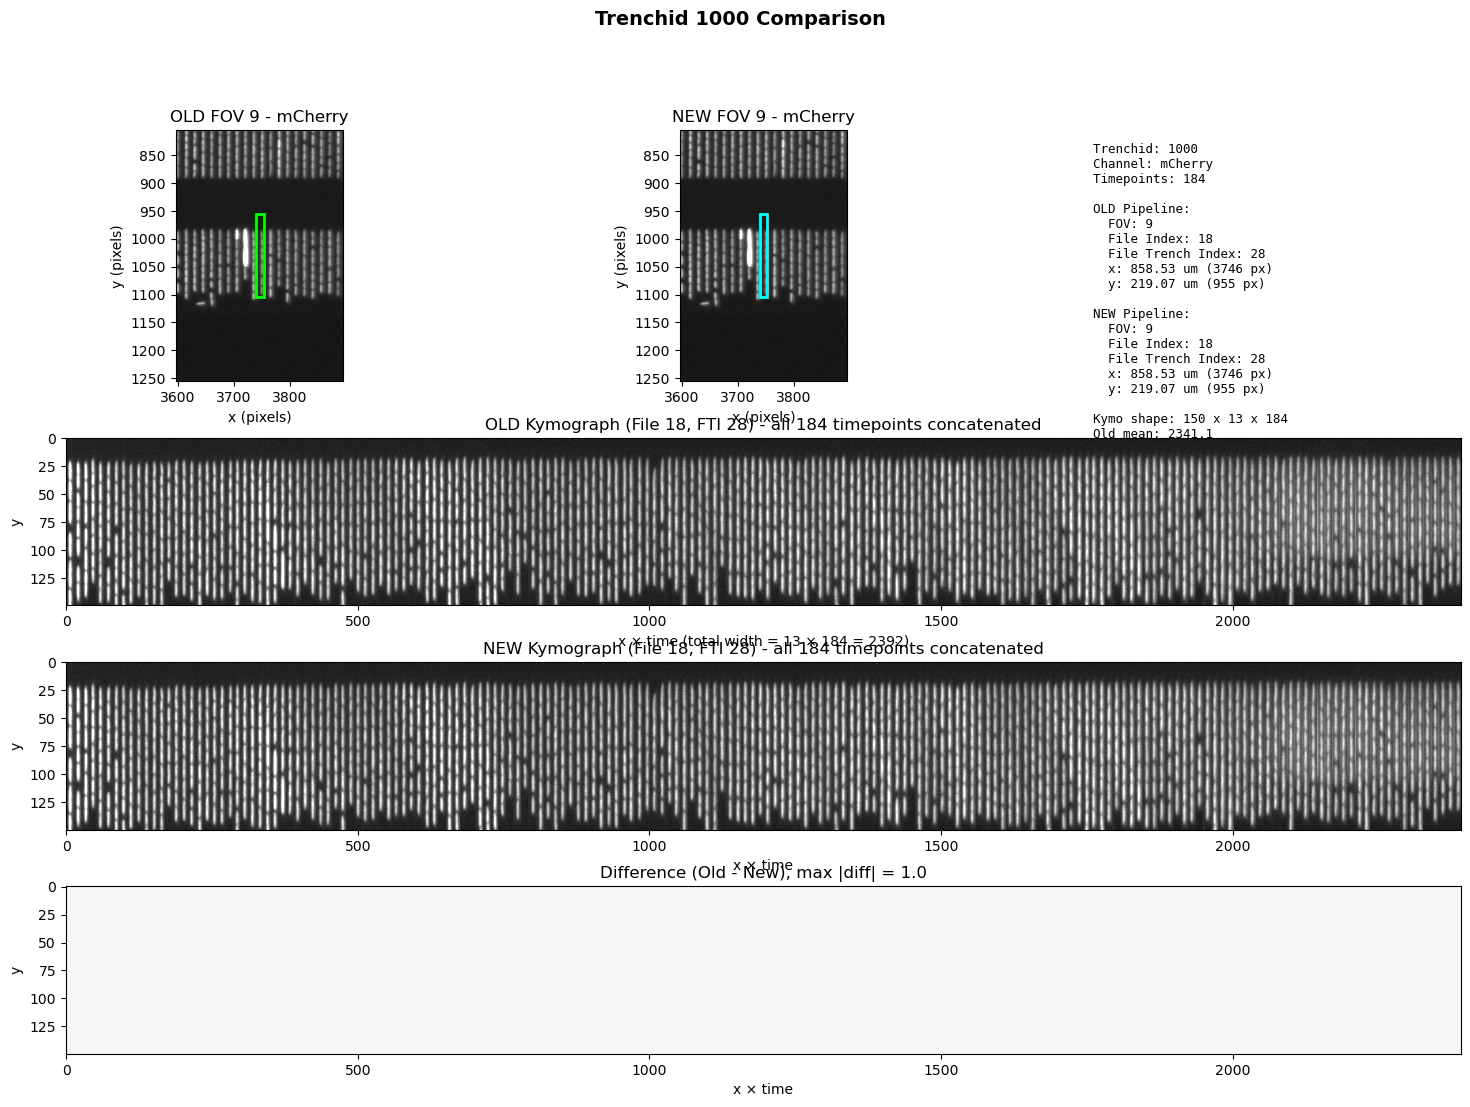

In [48]:
import h5py
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
basepath = "/home/nao5/new_scratch/251202_experiment/"

print("="*70)
print("VISUAL KYMOGRAPH COMPARISON")
print("="*70)

# Load metadata
old_kymo_meta = dd.read_parquet(basepath + "Growth_Division_old/kymograph/metadata").compute()
new_kymo_meta = dd.read_parquet(basepath + "Growth_Division_new/kymograph/metadata").compute()

# Pixel size
pixel_microns = tr.pandas_hdf5_handler(exp_dir + "Growth_Division_new/metadata.hdf5").\
                    read_df("global",read_metadata=True).metadata["pixel_microns"]
print(f"Using pixel_microns: {pixel_microns}")

# Paths
old_kymo_path = basepath + "Growth_Division_old/kymograph/"
new_kymo_path = basepath + "Growth_Division_new/kymograph/"
old_hdf5_path = basepath + "Growth_Division_old/hdf5/"
new_hdf5_path = basepath + "Growth_Division_new/hdf5/"

def visualize_trench_comparison(trenchid, timepoint=0, channel='mCherry'):
    """
    Visualize old vs new kymograph for a given trenchid, plus source FOV location
    """
    # Get metadata for this trenchid
    old_trench = old_kymo_meta[(old_kymo_meta['trenchid'] == trenchid) & 
                               (old_kymo_meta['timepoints'] == timepoint)]
    new_trench = new_kymo_meta[(new_kymo_meta['trenchid'] == trenchid) & 
                               (new_kymo_meta['timepoints'] == timepoint)]
    
    if len(old_trench) == 0 or len(new_trench) == 0:
        print(f"Trenchid {trenchid} not found in both datasets")
        return
    
    old_row = old_trench.iloc[0]
    new_row = new_trench.iloc[0]
    
    old_file_idx = int(old_row['File Index'])
    old_fti = int(old_row['File Trench Index'])
    new_file_idx = int(new_row['File Index'])
    new_fti = int(new_row['File Trench Index'])
    
    old_fov = int(old_row['fov'])
    new_fov = int(new_row['fov'])
    
    old_x_local = old_row['x (local)']
    old_y_local = old_row['y (local)']
    new_x_local = new_row['x (local)']
    new_y_local = new_row['y (local)']
    
    # Convert to pixels
    old_x_pixel = int(old_x_local / pixel_microns)
    old_y_pixel = int(old_y_local / pixel_microns)
    new_x_pixel = int(new_x_local / pixel_microns)
    new_y_pixel = int(new_y_local / pixel_microns)
    
    print(f"\nTrenchid {trenchid}:")
    print(f"  Old: FOV={old_fov}, File Index={old_file_idx}, FTI={old_fti}, x={old_x_local:.1f}um, y={old_y_local:.1f}um")
    print(f"  New: FOV={new_fov}, File Index={new_file_idx}, FTI={new_fti}, x={new_x_local:.1f}um, y={new_y_local:.1f}um")
    
    # Load data
    with h5py.File(old_kymo_path + f"kymograph_{old_file_idx}.hdf5", 'r') as old_kymo_h5, \
         h5py.File(new_kymo_path + f"kymograph_{new_file_idx}.hdf5", 'r') as new_kymo_h5, \
         h5py.File(old_hdf5_path + f"hdf5_{old_fov}.hdf5", 'r') as old_fov_h5, \
         h5py.File(new_hdf5_path + f"hdf5_{new_fov}.hdf5", 'r') as new_fov_h5:
        
        # Get kymograph data for ALL timepoints (shape: trench, time, y, x)
        old_kymo_all_t = old_kymo_h5[channel][old_fti, :, :, :]  # (T, Y, X)
        new_kymo_all_t = new_kymo_h5[channel][new_fti, :, :, :]  # (T, Y, X)
        
        n_timepoints, kymo_h, kymo_w = old_kymo_all_t.shape
        
        # Concatenate timepoints horizontally: (Y, X*T)
        old_kymo_concat = np.concatenate([old_kymo_all_t[t] for t in range(n_timepoints)], axis=1)
        new_kymo_concat = np.concatenate([new_kymo_all_t[t] for t in range(n_timepoints)], axis=1)
        
        # Get source FOV at first timepoint
        old_fov_data = old_fov_h5[channel][timepoint, :, :]
        new_fov_data = new_fov_h5[channel][timepoint, :, :]
        
        # Create figure
        fig = plt.figure(figsize=(18, 12))
        
        # Layout: 
        # Row 1: Old FOV (zoomed) | New FOV (zoomed) | Info
        # Row 2: Old kymograph (full time series)
        # Row 3: New kymograph (full time series)
        # Row 4: Difference
        
        gs = fig.add_gridspec(4, 3, height_ratios=[1.5, 1, 1, 1], hspace=0.3, wspace=0.3)
        
        # --- Row 1: FOV views ---
        margin = 150
        
        # Old FOV zoomed
        ax_old_fov = fig.add_subplot(gs[0, 0])
        y_start = max(0, old_y_pixel - margin)
        y_end = min(old_fov_data.shape[0], old_y_pixel + kymo_h + margin)
        x_start = max(0, old_x_pixel - margin)
        x_end = min(old_fov_data.shape[1], old_x_pixel + margin)
        
        vmax = np.percentile(old_fov_data, 99)
        ax_old_fov.imshow(old_fov_data[y_start:y_end, x_start:x_end], cmap='gray', vmin=0, vmax=vmax,
                          extent=[x_start, x_end, y_end, y_start])
        rect = patches.Rectangle((old_x_pixel - kymo_w//2, old_y_pixel), kymo_w, kymo_h,
                                   linewidth=2, edgecolor='lime', facecolor='none')
        ax_old_fov.add_patch(rect)
        ax_old_fov.set_title(f'OLD FOV {old_fov} - {channel}')
        ax_old_fov.set_xlabel('x (pixels)')
        ax_old_fov.set_ylabel('y (pixels)')
        
        # New FOV zoomed
        ax_new_fov = fig.add_subplot(gs[0, 1])
        y_start = max(0, new_y_pixel - margin)
        y_end = min(new_fov_data.shape[0], new_y_pixel + kymo_h + margin)
        x_start = max(0, new_x_pixel - margin)
        x_end = min(new_fov_data.shape[1], new_x_pixel + margin)
        
        vmax = np.percentile(new_fov_data, 99)
        ax_new_fov.imshow(new_fov_data[y_start:y_end, x_start:x_end], cmap='gray', vmin=0, vmax=vmax,
                          extent=[x_start, x_end, y_end, y_start])
        rect = patches.Rectangle((new_x_pixel - kymo_w//2, new_y_pixel), kymo_w, kymo_h,
                                   linewidth=2, edgecolor='cyan', facecolor='none')
        ax_new_fov.add_patch(rect)
        ax_new_fov.set_title(f'NEW FOV {new_fov} - {channel}')
        ax_new_fov.set_xlabel('x (pixels)')
        ax_new_fov.set_ylabel('y (pixels)')
        
        # Info panel
        ax_info = fig.add_subplot(gs[0, 2])
        ax_info.axis('off')
        
        corr = np.corrcoef(old_kymo_concat.flatten(), new_kymo_concat.flatten())[0, 1]
        info_text = f"""Trenchid: {trenchid}
Channel: {channel}
Timepoints: {n_timepoints}

OLD Pipeline:
  FOV: {old_fov}
  File Index: {old_file_idx}
  File Trench Index: {old_fti}
  x: {old_x_local:.2f} um ({old_x_pixel} px)
  y: {old_y_local:.2f} um ({old_y_pixel} px)
  
NEW Pipeline:
  FOV: {new_fov}
  File Index: {new_file_idx}
  File Trench Index: {new_fti}
  x: {new_x_local:.2f} um ({new_x_pixel} px)
  y: {new_y_local:.2f} um ({new_y_pixel} px)

Kymo shape: {kymo_h} x {kymo_w} x {n_timepoints}
Old mean: {old_kymo_concat.mean():.1f}
New mean: {new_kymo_concat.mean():.1f}
Correlation: {corr:.4f}
"""
        ax_info.text(0.05, 0.95, info_text, transform=ax_info.transAxes, fontsize=9,
                     verticalalignment='top', fontfamily='monospace')
        
        # --- Row 2: Old kymograph (concatenated) ---
        ax_old_kymo = fig.add_subplot(gs[1, :])
        vmax_kymo = np.percentile(np.concatenate([old_kymo_concat, new_kymo_concat]), 99)
        ax_old_kymo.imshow(old_kymo_concat, cmap='gray', aspect='auto', vmin=0, vmax=vmax_kymo)
        ax_old_kymo.set_title(f'OLD Kymograph (File {old_file_idx}, FTI {old_fti}) - all {n_timepoints} timepoints concatenated')
        ax_old_kymo.set_ylabel('y')
        ax_old_kymo.set_xlabel(f'x × time (total width = {kymo_w} × {n_timepoints} = {old_kymo_concat.shape[1]})')
        
        # --- Row 3: New kymograph (concatenated) ---
        ax_new_kymo = fig.add_subplot(gs[2, :])
        ax_new_kymo.imshow(new_kymo_concat, cmap='gray', aspect='auto', vmin=0, vmax=vmax_kymo)
        ax_new_kymo.set_title(f'NEW Kymograph (File {new_file_idx}, FTI {new_fti}) - all {n_timepoints} timepoints concatenated')
        ax_new_kymo.set_ylabel('y')
        ax_new_kymo.set_xlabel(f'x × time')
        
        # --- Row 4: Difference ---
        ax_diff = fig.add_subplot(gs[3, :])
        diff = old_kymo_concat.astype(float) - new_kymo_concat.astype(float)
        vabs = max(abs(diff.min()), abs(diff.max()), 1)
        ax_diff.imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vabs, vmax=vabs)
        ax_diff.set_title(f'Difference (Old - New), max |diff| = {vabs:.1f}')
        ax_diff.set_ylabel('y')
        ax_diff.set_xlabel(f'x × time')
        
        plt.suptitle(f'Trenchid {trenchid} Comparison', fontsize=14, fontweight='bold')
        plt.savefig(f'/mnt/user-data/outputs/trench_comparison_{trenchid}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved to trench_comparison_{trenchid}.png")

# Test with several trenchids
test_trenchids = [0, 10, 50, 100, 500, 1000]

for tid in test_trenchids:
    try:
        visualize_trench_comparison(tid, timepoint=0, channel='mCherry')
    except Exception as e:
        print(f"Error visualizing trenchid {tid}: {e}")

In [23]:
import numpy as np
import pickle
import os

print("="*70)
print("TRACING in_bounds COMPUTATION")
print("="*70)

# The in_bounds comes from get_all_in_bounds, which uses midpoints
# Let's check if there are any saved intermediate files we can compare

# First, let's add diagnostic code to save in_bounds during the pipeline
# For now, let's check what we can from the existing data

# The x_coords in metadata should reflect the in_bounds centers
# Let's compare x coordinates more carefully

old_kymo_meta = dd.read_parquet(basepath + "Growth_Division_old/kymograph/metadata").compute()
new_kymo_meta = dd.read_parquet(basepath + "Growth_Division_new/kymograph/metadata").compute()

# For File Index 0, get all trenches at timepoint 0
old_f0 = old_kymo_meta[(old_kymo_meta['File Index'] == 0) & (old_kymo_meta['timepoints'] == 0)].sort_values('File Trench Index')
new_f0 = new_kymo_meta[(new_kymo_meta['File Index'] == 0) & (new_kymo_meta['timepoints'] == 0)].sort_values('File Trench Index')

print("File Index 0, Timepoint 0:")
print(f"Old: {len(old_f0)} trenches")
print(f"New: {len(new_f0)} trenches")

# The x (local) values should be in the same order if in_bounds is computed the same way
print("\n--- x (local) values by File Trench Index ---")
print(f"{'FTI':<5} | {'Old x (local)':<15} | {'New x (local)':<15} | {'Old trenchid':<12} | {'New trenchid':<12}")
print("-" * 70)

for fti in range(min(20, len(old_f0))):
    old_row = old_f0[old_f0['File Trench Index'] == fti].iloc[0]
    new_row = new_f0[new_f0['File Trench Index'] == fti].iloc[0]
    print(f"{fti:<5} | {old_row['x (local)']:<15.2f} | {new_row['x (local)']:<15.2f} | {int(old_row['trenchid']):<12} | {int(new_row['trenchid']):<12}")

# Now the key question: for the SAME x (local) value, what's in the HDF5?
# Let's pick a specific x coordinate and see what's actually stored

print("\n\n--- Checking actual HDF5 data at specific x coordinates ---")

# Pick trenchid 50 (from your visualization)
tid = 50
old_tid_row = old_kymo_meta[(old_kymo_meta['trenchid'] == tid) & (old_kymo_meta['timepoints'] == 0)].iloc[0]
new_tid_row = new_kymo_meta[(new_kymo_meta['trenchid'] == tid) & (new_kymo_meta['timepoints'] == 0)].iloc[0]

print(f"\nTrenchid {tid}:")
print(f"  Old: File Index={int(old_tid_row['File Index'])}, FTI={int(old_tid_row['File Trench Index'])}, x={old_tid_row['x (local)']:.2f}")
print(f"  New: File Index={int(new_tid_row['File Index'])}, FTI={int(new_tid_row['File Trench Index'])}, x={new_tid_row['x (local)']:.2f}")

# The metadata says both should be at the same location
# But the HDF5 data is different
# This means the METADATA is being generated AFTER the HDF5 is written
# And the HDF5 writing order is different from the metadata order

print("\n\nCONCLUSION:")
print("The metadata (x coordinates, File Trench Index) is generated correctly")
print("But the HDF5 data is written in a DIFFERENT ORDER than the metadata expects")
print("The issue is in how in_bounds is ordered when crop_x writes to HDF5")

TRACING in_bounds COMPUTATION
File Index 0, Timepoint 0:
Old: 54 trenches
New: 54 trenches

--- x (local) values by File Trench Index ---
FTI   | Old x (local)   | New x (local)   | Old trenchid | New trenchid
----------------------------------------------------------------------
0     | 3.55            | 3.55            | 0            | 0           
1     | 6.99            | 6.99            | 1            | 1           
2     | 10.43           | 10.43           | 2            | 2           
3     | 13.86           | 13.86           | 3            | 3           
4     | 17.53           | 17.53           | 4            | 4           
5     | 20.97           | 20.97           | 5            | 5           
6     | 24.41           | 24.41           | 6            | 6           
7     | 27.84           | 27.84           | 7            | 7           
8     | 31.28           | 31.28           | 8            | 8           
9     | 51.90           | 51.90           | 9            | 9           

##### Check kymograph statistics

Run the next line to display some statistics from kymograph creation. The outputs are:

 - **fovs processed** : The number of FOVs successfully processed out of the total number of FOVs
 - **rows processed** : The number of rows of trenches processed out of the total number of rows
 - **trenches processed** : The number of trenches successfully processed
 - **row/fov** : The average number of rows successfully processed per FOV
 - **trenches/fov** : The average number of trenches successfully processed per FOV
 - **failed fovs** : A list of failed FOVs. Spot check these FOVs in the viewer to determine potential problems

In [38]:
kymoclust.kymo_report()

fovs processed: 492/494
rows processed: 3922
trenches processed: 938653
row/fov: 7.971544715447155
trenches/fov: 1907.831300813008
failed fovs: [125, 55]


In [39]:
import h5py
import os

# Check which processed files remain
proc_files = sorted([f for f in os.listdir(kymoclust.kymographpath) if f.startswith("kymograph_processed_")])
print(f"Remaining processed files: {proc_files}")

# Extract their indices
proc_indices = [int(f.replace('kymograph_processed_', '').replace('.hdf5', '')) for f in proc_files]
print(f"Processed file indices: {proc_indices}")

# Check if the corresponding output kymograph files exist and are valid
print("\nChecking corresponding output files:")
for idx in proc_indices:
    output_file = f"kymograph_{idx}.hdf5"
    output_path = kymoclust.kymographpath + "/" + output_file
    
    if os.path.exists(output_path):
        with h5py.File(output_path, 'r') as f:
            keys = list(f.keys())
            if keys:
                shapes = {k: f[k].shape for k in keys}
                print(f"  {output_file}: EXISTS, channels={keys}, shapes={shapes}")
            else:
                print(f"  {output_file}: EXISTS but EMPTY")
    else:
        print(f"  {output_file}: MISSING")

# Also do a quick overall health check
kymo_files = sorted([f for f in os.listdir(kymoclust.kymographpath) 
                     if f.startswith("kymograph_") and f.endswith(".hdf5") 
                     and not f.startswith("kymograph_processed")])

empty_count = 0
good_count = 0
for f in kymo_files:
    with h5py.File(kymoclust.kymographpath + "/" + f, 'r') as hf:
        if len(hf.keys()) == 0:
            empty_count += 1
        else:
            good_count += 1

print(f"\nOverall: {good_count} good files, {empty_count} empty files out of {len(kymo_files)} total")

Remaining processed files: ['kymograph_processed_500.hdf5', 'kymograph_processed_501.hdf5', 'kymograph_processed_502.hdf5', 'kymograph_processed_503.hdf5']
Processed file indices: [500, 501, 502, 503]

Checking corresponding output files:
  kymograph_500.hdf5: EXISTS, channels=['CFP', 'mCherry'], shapes={'CFP': (138, 180, 150, 15), 'mCherry': (138, 180, 150, 15)}
  kymograph_501.hdf5: EXISTS, channels=['CFP', 'mCherry'], shapes={'CFP': (138, 180, 150, 15), 'mCherry': (138, 180, 150, 15)}
  kymograph_502.hdf5: EXISTS, channels=['CFP', 'mCherry'], shapes={'CFP': (138, 180, 150, 15), 'mCherry': (138, 180, 150, 15)}
  kymograph_503.hdf5: EXISTS, channels=['CFP', 'mCherry'], shapes={'CFP': (138, 180, 150, 15), 'mCherry': (138, 180, 150, 15)}

Overall: 6802 good files, 0 empty files out of 6802 total


## Fluorescence Segmentation

Now that you have copped your data into kymographs, we will now perform segmentation/cell detection <br>
on your kymographs. Currently, this pipeline only supports segmentation of fluorescence images; however, <br>
segmentation of transmitted light imaging techniques is in development.

The output of this step will be a set of `segmentation_[File #].hdf5` files stored in `headpath/fluorsegmentation`.<br>
The image data stored in these files takes the exact same form as the kymograph data, `(K,T,Y,X)` arrays <br>
where K is the trench index, T is time, and Y,X are the crop dimensions. These arrays are accessible using <br>
keys of the form `"[Trench Row Number]"`.

Since no metadata is generated by this step, it is possible to use another segmentation algorithm on the kymograph <br>
data. The output of segmentation must be split into `segmentation_[File #].hdf5` files, where `[File #]` agrees with the<br>
corresponding `kymograph_[File #].hdf5` file. Additionally, the `(K,T,Y,X)` arrays must be of the same shape as the <br>
kymograph arrays and accessible at the corresponding `"[Trench Row Number]"` key. These files must be placed into <br>
their own folder at `headpath/foldername`. This folder may then be used in later steps.

### Test Parameters

#### Typical parameters for mCherry single channel imaging at 20x

- Extra Mask Path: None
- 8 Bit Maximum: 6000
- Scale Fluorescence? False
- Scaling Percentile: 90
- Image Scaling Factor: 1.0
- Gaussian Kernel Sigma: 1.0
- Local Threshold Method: otsu
- Background Threshold Method: triangle
- Global Threshold: 18
- Local Window Size: 11
- Otsu Scaling: 0.9999999999999999
- Niblack K: 0.2
- Background Threshold Scaling: 1.0
- Minimum Object Size: 20
- Hessian Blur Sigma: 1.75
- Hessian Rolling Ball Size: 20
- Hessian Local Threshold Method: niblack
- Hessian Otsu Scaling: 0.9999999999999999
- Hessian Niblack K: 0.05
- Hessian Local Window Size: 7
- Distance Threshold: 1
- Border Buffer: 1
- Horizontal Border Only: False
- Segmentation Channel: mCherry

##### Initialize the interactive segmentation class

As a first step, initialize the `tr.fluo_segmentation_interactive` class that will be handling all steps of generating a segmentation. 

In [15]:
interactive_segmentation = tr.fluo_segmentation_interactive(headpath)

/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


##### Choose channel to segment on

In [16]:
interactive_segmentation.choose_seg_channel_inter()

interactive(children=(Dropdown(description='seg_channel', options=('mCherry', 'CFP'), value='mCherry'), Dropdo…

#### Import data

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**fov_idx (int)** :

**n_trenches (int)** :

**t_range (tuple)** :

**t_subsample_step (int)** :

In [17]:
interactive_segmentation.import_array_inter()

interactive(children=(IntText(value=12, description='Number of trenches:'), IntRangeSlider(value=(0, 179), des…

##### Process data

In [18]:
interactive_segmentation.plot_processed_inter()

interactive(children=(IntSlider(value=1250, description='8-bit Maximum:', max=65535, step=250), Dropdown(descr…

#### Determine Cell Mask Envelope

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**cell_mask_method (str)** : Thresholding method, can be a local or global Otsu threshold.

**cell_otsu_scaling (float)** : Scaling factor applied to determined threshold.

**local_otsu_r (int)** : Radius of thresholding kernel used in the local otsu thresholding.

In [19]:
interactive_segmentation.plot_cell_mask_inter()

interactive(children=(Dropdown(description='local_thr', options=('otsu', 'niblack', 'none'), value='otsu'), Dr…

In [21]:
interactive_segmentation.plot_eig_mask_inter()

interactive(children=(FloatSlider(value=1.5, description='Hessian Blur Sigma:', max=5.0, step=0.25), IntSlider…

In [22]:
interactive_segmentation.plot_dist_mask_inter()

interactive(children=(IntSlider(value=1, description='Distance Threshold:', max=20), Button(description='Run I…

In [23]:
interactive_segmentation.plot_marker_mask_inter()

interactive(children=(FloatSlider(value=1.5, description='Hessian Blur Sigma:', max=5.0, step=0.25), IntSlider…

In [24]:
interactive_segmentation.process_results()

Extra Mask Path: None
8 Bit Maximum: 9000
Scale Fluorescence? False
Scaling Percentile: 90
Image Scaling Factor: 1.0
Gaussian Kernel Sigma: 0.75
Local Threshold Method: otsu
Background Threshold Method: triangle
Global Threshold: 0
Local Window Size: 9
Otsu Scaling: 0.9999999999999999
Niblack K: 0.2
Background Threshold Scaling: 1.0
Minimum Object Size: 20
Hessian Blur Sigma: 1.75
Hessian Rolling Ball Size: 10
Hessian Local Threshold Method: otsu
Hessian Otsu Scaling: 0.9
Hessian Niblack K: 0.15
Hessian Local Window Size: 7
Distance Threshold: 1
Border Buffer: 1
Horizontal Border Only: False
Segmentation Channel: mCherry


In [25]:
interactive_segmentation.write_param_file()

In [ ]:
dask_controller.shutdown()

Done.


# Generate Segmentation

#### Start Dask Workers

In [4]:
dask_controller = tr.trcluster.dask_controller(
    walltime="3:00:00",
    local=False,
    n_workers=500,
    n_workers_min=20,
    memory="2GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

170m
3:00:00


In [5]:
dask_controller.displaydashboard()

In [6]:
segment = tr.segment.fluo_segmentation_cluster(headpath, paramfile=True)

In [7]:
segment.dask_segment(dask_controller, overwrite=True)

Done.


#### Stop Dask Workers

In [18]:
dask_controller.shutdown()

Done.


# Region Props

In [4]:
dask_controller = tr.trcluster.dask_controller(
    walltime="1:00:00",
    local=False,
    n_workers=400,
    n_workers_min=20,
    memory="4GB",
    death_timeout=60.,
    working_directory=dask_wd,
)
dask_controller.startdask()


50m
1:00:00


In [5]:
dask_controller.displaydashboard()

In [8]:
analyzer = tr.regionprops_extractor(headpath,
                                    "fluorsegmentation",
                                    intensity_channel_list=["mCherry", "CFP"],
                                    size_estimation=True,
                                    size_estimation_method="Perimeter/Area",  # or "Ellipse"
                                    include_background = False)

/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [9]:
analyzer.analyze_all_files(dask_controller)

Beginning Region Props Extraction
Progress: 6801/6802 finished, 0 errors
1. Creating dataframe from delayed...
   Done. Partitions: 6802
2. Setting File Parquet Index column...
   Done.
3. Setting index...
   Done.
4. Repartitioning...
   Done. New partitions: 6794
5. Reading kymo metadata...
   Done.
6. Preparing kymo_df for join...
   Done.
7. Preparing df_out for join...


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/dataframe/dask_expr/_collection.py:3250: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))


   Done.
8. Joining dataframes...
   Done.
9. Setting final index...
10. Writing to parquet...
   Done.
Complete!


In [10]:
dask_controller.shutdown()

Done.


# Part 2: Barcodes

#### Specify Paths

Begin by defining the directory in which all processing will be done, as well as the initial nd2 file we will be <br>processing. This line should be run everytime you open a new python kernel.

The format should be: `headpath = "/path/to/folder"` and `nd2file = "/path/to/file.nd2"`

For example:
```
headpath = "/n/scratch2/de64/2019-05-31_validation_data"
nd2file = "/n/scratch2/de64/2019-05-31_validation_data/Main_Experiment.nd2"
```

Ideally, these files should be placed in a storage location with relatively fast I/O

In [11]:
exp_dir = "/n/scratch/users/n/nao5/251209_experiment/"
headpath = exp_dir + "Barcodes"
hdf5inputpath = exp_dir + "FISH"

## Extract to hdf5 files

In this section, we will be extracting our image data. Currently this notebook only supports `.nd2` format; however <br>there are `.tiff` extractors in the TrenchRipper source files that are being added to `Master.ipynb` soon.

In the abstract, this step will take a single `.nd2` file and split it into a set of `.hdf5` files stored in <br>`headpath/hdf5`. Splitting the file up in this way will facilitate quick procesing in later steps. Each field of <br>view will be split into one or more `.hdf5` files, depending on the number of images per file requested (more on <br>this later). 

To keep track of which output files correspond to which FOVs, as well as to keep track of experiment metadata, the <br>extractor also outputs a `metadata.hdf5` file in the `headpath` folder. The data from this step is accessible in <br>that `metadata.hdf5` file under the `global` key. If you would like to look at this metadata, you may use the <br>`tr.utils.pandas_hdf5_handler` to read from this file. Later steps will add additional metadata under different <br>keys into the `metadata.hdf5` file.

#### Start Dask Workers

First, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

In [23]:
dask_controller = tr.trcluster.dask_controller(
    walltime="1:00:00",
    local=False,
    n_workers=100,
    n_workers_min=10,
    memory="8GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

50m
1:00:00


In [24]:
dask_controller.displaydashboard()

##### Perform Extraction

Now that we have our cluster scheduler spun up, it is time to convert files. This will be handled by the <br>`hdf5_extractor` object. This extractor will pull up each FOV and split it such that each derived `.hdf5` file <br>contains, at maximum, N timepoints of that FOV per file. The image data stored in these files takes the <br>form of `(N,Y,X)` arrays that are accessible using the desired channel name as a key. 

The arguments for this extractor are:

 - **nd2file** : The filepath to the `.nd2` file you intend to extract.
 
 - **headpath** : The folder in which processing is occuring. Should be the same for each step in the pipeline.

 - **tpts_per_file** : The maximum number of timepoints stored in each output `.hdf5` file. Typical values are between 25 <br>and 100.

 - **ignore_fovmetadata** : Used when `.nd2` data is corrupted and does not possess records for stage positions or <br>timepoints. Only set `False` if the extractor throws errors on metadata handling.

 - **nd2reader_override** : Overrides values in metadata recovered using the `nd2reader`. Currently set to <br>`{"z_levels":[],"z_coordinates":[]}` by default to correct a known issue where z coordinates are mistakenly <br>interpreted as a z stack. See the [nd2reader](https://rbnvrw.github.io/nd2reader/) documentation for more info.

In [15]:
nd_pixel_microns = tr.pandas_hdf5_handler(exp_dir + "Growth_Division/metadata.hdf5").\
                    read_df("global",read_metadata=True).metadata["pixel_microns"]
hdf5_extractor = tr.marlin_extractor(hdf5inputpath, headpath, pixel_microns=nd_pixel_microns, metaparsestr='metadata_{timepoint:d}.hdf5',\
                                    parsestr='fov={fov:d}_config={channel}_t={timepoints:d}')

/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


##### Extraction Parameters

Here, you may set the time interval you want to extract. Useful for cropping data to the period exhibiting the dynamics of interest.

Optionally take notes to add to the `metadata.hdf5` file. Notes may also be taken directly in this notebook.

In [16]:
hdf5_extractor.inter_set_params()

/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:86: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['channel_paths', 'config'], dtype='object')]

  store.put(key, df)
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


interactive(children=(SelectMultiple(description='fov_list', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

#### List of paths to flat fields


/n/scratch/users/n/nao5/flat_field/Ti7/processed_flatfield/GFP_norm.tif
/n/scratch/users/n/nao5/flat_field/Ti7/processed_flatfield/Cy5_norm.tif
/n/scratch/users/n/nao5/flat_field/Ti7/processed_flatfield/Cy7_norm.tif
/n/scratch/users/n/nao5/flat_field/Ti7/processed_flatfield/dark.tif


In [17]:
hdf5_extractor.inter_set_flatfieldpaths()

##### Begin Extraction 

Running the following line will start the extraction process. This may be monitored by examining the `Dask Dashboard` <br> under the link displayed earlier. Once the computation is complete, move to the next line.

This step may take a long time, though it is possible to speed it up using additional workers.

In [18]:
hdf5_extractor.extract(dask_controller)

/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:86: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['channel_paths', 'config'], dtype='object')]

  store.put(key, df)
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/path.py:137: Nat

In [20]:
import os
import h5py
import numpy as np
import gc
from dask.distributed import as_completed, wait
from typing import List, Optional
import logging

# Set up logging
logger = logging.getLogger(__name__)

# Remove @delayed decorator - this function will be submitted directly
def process_synthetic_bf(filepath: str) -> tuple[str, bool, Optional[str]]:
    """
    Process a single HDF5 file to create synthetic brightfield channel.
    This function runs on Dask workers.
    
    Args:
        filepath: Path to the HDF5 file
        
    Returns:
        Tuple of (filepath, success_status, error_message)
    """
    try:
        with h5py.File(filepath, "a") as infile:
            # Read and process each channel
            channels = ["GFP", "Cy5", "Cy7"]
            normalized_arrays = []
            
            for channel in channels:
                if channel not in infile:
                    raise KeyError(f"Channel {channel} not found in {filepath}")
                
                # Calculate 98th percentile along first axis
                channel_data = infile[channel][:]
                perc_arr = np.percentile(channel_data, 98, axis=0)
                
                # Normalize by maximum value
                max_val = perc_arr.max()
                if max_val > 0:
                    normalized = perc_arr / max_val
                else:
                    normalized = perc_arr
                    
                normalized_arrays.append(normalized)
                
                # Explicitly delete large array to free memory
                del channel_data
            
            # Stack normalized arrays
            im_arr = np.stack(normalized_arrays, axis=0)
            
            # Calculate final synthetic BF
            perc_arr = 10000 * np.percentile(im_arr, 98, axis=0)
            perc_arr_repeat = np.stack([perc_arr for _ in range(10)], axis=0).astype("uint16")
            
            # Replace BF channel
            if "BF" in infile:
                del infile["BF"]
            infile.create_dataset("BF", data=perc_arr_repeat, compression="gzip", compression_opts=1)
            
            # Clean up
            del im_arr, perc_arr, perc_arr_repeat, normalized_arrays
            
        return (filepath, True, None)
        
    except Exception as e:
        error_msg = f"Error processing {filepath}: {str(e)}"
        logger.error(error_msg)
        return (filepath, False, error_msg)
    finally:
        # Force garbage collection to free memory
        gc.collect()


def batch_process_synthetic_bf(
    exp_dir: str,
    dask_client,
    batch_size: int = 50,
    progress_callback=None
) -> dict:
    """
    Process multiple HDF5 files using Dask with proper memory management.
    
    Args:
        exp_dir: Experiment directory containing Barcodes/hdf5/ folder
        dask_client: Dask client instance
        batch_size: Number of files to process in parallel
        progress_callback: Optional callback function for progress updates
        
    Returns:
        Dictionary with results and statistics
    """
    # Gather file paths
    hdf5_path = os.path.join(exp_dir, "Barcodes_new", "hdf5")
    
    if not os.path.exists(hdf5_path):
        raise FileNotFoundError(f"HDF5 path does not exist: {hdf5_path}")
    
    all_file_paths = [
        os.path.join(hdf5_path, f) 
        for f in os.listdir(hdf5_path) 
        if f.endswith(".hdf5")
    ]
    
    if not all_file_paths:
        logger.warning(f"No HDF5 files found in {hdf5_path}")
        return {"processed": [], "failed": [], "total": 0}
    
    logger.info(f"Found {len(all_file_paths)} HDF5 files to process")
    
    # Process files in batches to control memory usage
    results = {
        "processed": [],
        "failed": [],
        "total": len(all_file_paths)
    }
    
    # Process in batches
    for i in range(0, len(all_file_paths), batch_size):
        batch_paths = all_file_paths[i:i + batch_size]
        futures = []
        
        for filepath in batch_paths:
            # Submit the function directly (no @delayed)
            future = dask_client.submit(
                process_synthetic_bf, 
                filepath,
                priority=1,  # Set priority if needed
                retries=1    # Allow one retry on failure
            )
            futures.append(future)
        
        # Wait for batch to complete before starting next batch
        completed_futures = wait(futures)
        
        # Process results
        for future in completed_futures.done:
            try:
                filepath, success, error = future.result()
                if success:
                    results["processed"].append(filepath)
                    logger.info(f"Successfully processed: {os.path.basename(filepath)}")
                else:
                    results["failed"].append((filepath, error))
                    logger.error(f"Failed to process: {os.path.basename(filepath)}")
            except Exception as e:
                logger.error(f"Error retrieving result: {str(e)}")
                
        # Optional progress callback
        if progress_callback:
            progress = len(results["processed"]) + len(results["failed"])
            progress_callback(progress, results["total"])
        
        # Release futures to free memory
        del futures
        
        # Force garbage collection between batches
        gc.collect()
    
    # Log summary
    logger.info(f"Processing complete: {len(results['processed'])} successful, "
                f"{len(results['failed'])} failed out of {results['total']} files")
    
    return results


def batch_process_synthetic_bf_alternative(
    exp_dir: str,
    dask_client,
    max_workers: int = 50
) -> dict:
    """
    Alternative implementation using as_completed for streaming results.
    Optimized for clusters with many workers.
    
    Args:
        exp_dir: Experiment directory
        dask_client: Dask client instance
        max_workers: Maximum concurrent tasks (set slightly higher than worker count)
        
    Returns:
        Dictionary with results
    """
    hdf5_path = os.path.join(exp_dir, "Barcodes", "hdf5")
    
    if not os.path.exists(hdf5_path):
        raise FileNotFoundError(f"HDF5 path does not exist: {hdf5_path}")
    
    all_file_paths = [
        os.path.join(hdf5_path, f) 
        for f in os.listdir(hdf5_path) 
        if f.endswith(".hdf5")
    ]
    
    if not all_file_paths:
        logger.warning(f"No HDF5 files found in {hdf5_path}")
        return {"processed": [], "failed": [], "total": 0}
    
    logger.info(f"Found {len(all_file_paths)} HDF5 files to process")
    
    results = {
        "processed": [],
        "failed": [],
        "total": len(all_file_paths)
    }
    
    # Submit all tasks but process results as they complete
    futures = {}
    
    # Submit initial batch
    for filepath in all_file_paths[:min(max_workers, len(all_file_paths))]:
        future = dask_client.submit(process_synthetic_bf, filepath, priority=1)
        futures[future] = filepath
    
    remaining_paths = all_file_paths[min(max_workers, len(all_file_paths)):]
    
    # Process as completed and submit new tasks
    completed_count = 0
    for future in as_completed(futures):
        completed_count += 1
        try:
            filepath, success, error = future.result()
            
            if success:
                results["processed"].append(filepath)
                logger.info(f"[{completed_count}/{len(all_file_paths)}] Processed: {os.path.basename(filepath)}")
            else:
                results["failed"].append((filepath, error))
                logger.error(f"[{completed_count}/{len(all_file_paths)}] Failed: {os.path.basename(filepath)}: {error}")
                
        except Exception as e:
            filepath = futures[future]
            results["failed"].append((filepath, str(e)))
            logger.error(f"[{completed_count}/{len(all_file_paths)}] Failed: {os.path.basename(filepath)}: {e}")
        
        # Remove completed future
        del futures[future]
        
        # Submit next file if any remaining
        if remaining_paths:
            next_path = remaining_paths.pop(0)
            new_future = dask_client.submit(process_synthetic_bf, next_path, priority=1)
            futures[new_future] = next_path
    
    logger.info(f"Processing complete: {len(results['processed'])} successful, "
                f"{len(results['failed'])} failed out of {results['total']} files")
    
    return results


# Simple wrapper that matches your original function signature
def synthetic_BF(filepath: str) -> int:
    """
    Simple wrapper function that matches your original API.
    Can be used with client.submit() directly.
    
    Args:
        filepath: Path to HDF5 file
        
    Returns:
        1 on success, raises exception on failure
    """
    with h5py.File(filepath, "a") as infile:
        # Process channels
        GFP_arr = np.percentile(infile["GFP"][:], 98, axis=0)
        Cy5_arr = np.percentile(infile["Cy5"][:], 98, axis=0)
        Cy7_arr = np.percentile(infile["Cy7"][:], 98, axis=0)
        
        GFP_arr = GFP_arr / GFP_arr.max()
        Cy5_arr = Cy5_arr / Cy5_arr.max()
        Cy7_arr = Cy7_arr / Cy7_arr.max()
    
        im_arr = np.stack([GFP_arr, Cy5_arr, Cy7_arr], axis=0)
        perc_arr = 10000 * np.percentile(im_arr, 98, axis=0)
        perc_arr_repeat = np.stack([perc_arr for i in range(10)], axis=0).astype("uint16")
        
        if "BF" in infile:
            del infile["BF"]
        infile["BF"] = perc_arr_repeat
        
    return 1



In [ ]:
results = batch_process_synthetic_bf_alternative(
    exp_dir=exp_dir,
    dask_client=dask_controller.daskclient,
    max_workers=500  
)

##### Shutdown Dask

Once extraction is complete, it is likely that you will want to shutdown your `dask_controller` if you are on a <br>
cluster. This is because the specifications of the current `dask_controller` will not be optimal for later steps. <br>
To do this, run the following line and wait for it to complete. If it hangs, interrupt your kernel and re-run it. <br>
If this also fails to shutdown your workers, you will have to manually shut them down using `scancel` in a terminal.

In [57]:
dask_controller.shutdown()

Done.


2025-12-16 20:10:35,943 - distributed.scheduler - ERROR - Removing worker 'tcp://10.120.16.163:43603' caused the cluster to lose scattered data, which can't be recovered: {'DataFrame-6454b4ea6468d24d0a6c768c481e1d5a'} (stimulus_id='handle-worker-cleanup-1765933835.943687')


## Kymographs

Now that you have extracted your data into a series of `.hdf5` files, we will now perform identification and cropping <br>of the individual trenches/growth channels present in the images. This algorithm assumes that your growth trenches <br>are vertically aligned and that they alternate in their orientation from top to bottom. See the example image for the <br>correct geometry:

![example_image](./resources/example_image.jpg)

The output of this step will be a set of `.hdf5` files stored in `headpath/kymograph`. The image data stored in these <br>files takes the form of `(K,T,Y,X)` arrays where K is the trench index, T is time, and Y,X are the crop dimensions. <br>These arrays are accessible using keys of the form `"[Image Channel]"`. For example, looking up phase channel <br>data of trenches in the topmost row of an image will require the key `"Phase"`

### Test Parameters

#### Typical parameters for 20x FISH decoding

- Y Percentile 99
- Y Foreground Percentile 65
- Y Smoothing Kernel 51
- Y Percentile Threshold 0.5
- Minimum Trench Length 80
- Midpoint Distance Tolerance 50
- Y Padding 20
- Trench Length 130
- Orientation Detection Method 1
- Expected Number of Rows (Manual Orientation Detection) 10
- Alternate Orientation True
- Alternate Orientation Over Rows? False
- Use Median Drift? False
- X Percentile 50
- X Background Kernel 21
- X Smoothing Kernel 5
- Otsu Threshold Scaling 0.0
- Minimum X Threshold 500
- Trench Width 14
- Trench Presence Threshold 1.0
- All Channels ['BF', 'Cy7', 'Cy5', 'RFP']
- Filter Channel None
- Invert False

##### Initialize the interactive kymograph class

As a first step, initialize the `tr.interactive.kymograph_interactive` class that will be help us choose the <br>parameters we will use to generate kymographs. 

In [25]:
interactive_kymograph = tr.kymograph_interactive(headpath)

/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [26]:
viewer = tr.hdf5_viewer(headpath,persist_data=False)

/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


##### Examine Images

Here you can manually inspect images before beginning parameter tuning.

In [ ]:
viewer.view(width=1200)

You will now want to select a few test FOVs to try out parameters on, the channel you want to detect trenches on, and <br>the time interval on which you will perform your processing.

The arguments for this step are:

- **seg_channel (string)** : The channel name that you would like to segment on.

- **invert (list)** : Whether or not you want to invert the image before detecting trenches. By default, it is assumed that <br>the trenches have a high pixel intensity relative to the background. This should be the case for Phase Contrast and <br>Fluorescence Imageing, but may not be the case for Brightfield Imaging, in which case you will want to invert the image.

- **fov_list (list)** : List of integers corresponding to the FOVs that you wish to make test kymographs of.

- **t_subsample_step (int)** : Step size to be used for subsampling input files in time, recommend that subsampling results in <br>between 5 and 10 timepoints for quick processing.

Hit the "Run Interact" button to lock in your parameters. The button will become transparent briefly and become solid again <br>when processing is complete. After that has occured, move on to the next step. 

In [28]:
interactive_kymograph.import_hdf5_interactive()

interactive(children=(Dropdown(description='seg_channel', options=('Cy7', 'BF', 'GFP', 'Cy5'), value='Cy7'), D…

##### Tune "trench-row" detection hyperparameters

The kymograph code begins by detecting the positions of trench rows in the image as follows:

1. Reducing each 2D image to a 1D signal along the y-axis by computing the qth percentile of the data along the x-axis
2. Smooth this signal using a median kernel
3. Normalize the signal by linearly scaling 0. and 1. to the minimum and maximum, respectively
4. Use a set threshold to determine the trench row poisitons

The arguments for this step are:

 - **y_percentile (int)** : Percentile to use for step 1.

 - **smoothing_kernel_y_dim_0 (int)** : Median kernel size to use for step 2.

 - **y_percentile_threshold (float)** : Threshold to use in step 4.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold <br>value for each fov will be displayed as a red line.

In [29]:
interactive_kymograph.preview_y_precentiles_interactive()

interactive(children=(IntSlider(value=95, description='y_percentile'), IntSlider(value=65, description='y_fore…

In [31]:
interactive_kymograph.preview_y_precentiles_consensus_interactive()

interactive(children=(IntSlider(value=50, description='n_fovs', step=5), Dropdown(description='Y Consensus Ena…

##### Tune "trench-row" cropping hyperparameters

Next, we will use the detected rows to perform cropping of the input image in the y-dimension:

1. Determine edges of trench rows based on threshold mask.
2. Filter out rows that are too small.
3. Use the remaining rows to compute the drift in y in each image.
4. Apply the drift to the initally detected rows to get rows in all timepoints.
5. Perform cropping using the "end" of the row as reference (the end referring to the part of the trench farthest from <br>the feeding channel).

Step 5 performs a simple algorithm to determine the orientation of each trench:

```
row_orientations = [] # A list of row orientations, starting from the topmost row
if the number of detected rows == 'Number of Rows': 
    row_orientations.append('Orientation')
elif the number of detected rows < 'Number of Rows':
    row_orientations.append('Orientation when < expected rows')
for row in rows:
    if row_orientations[-1] == downward:
        row_orientations.append(upward)
    elif row_orientations[-1] == upward:
        row_orientations.append(downward)
```

Additionally, if the device tranches face a single direction, alternation of row orientation may be turned off by setting the<br> `Alternate Orientation?` argument to False. The `Use Median Drift?` argument, when set to True, will use the<br> median drift in y across all FOVs for drift correction, instead of doing drift correction independently for all FOVs. <br>This can be useful if there are a large fraction of FOVs which are failing drift correction. Note that `Use Median Drift?` <br>sets this behavior for both y and x drift correction.

The arguments for this step are:

 - **y_min_edge_dist (int)** : Minimum row length necessary for detection (filters out small detected objects).

 - **padding_y (int)** : Padding to add to the end of trench row when cropping in the y-dimension.

 - **trench_len_y (int)** : Length from the end of each trench row to the feeding channel side of the crop.

 - **Number of Rows (int)** : The number of rows to expect in your image. For instance, two in the example image.
 
 - **Alternate Orientation? (bool)** : Whether or not to alternate the orientation of consecutive rows.

 - **Orientation (int)** : The orientation of the top-most row where 0 corresponds to a trench with a downward-oriented trench <br>opening and 1 corresponds to a trench with an upward-oriented trench opening.

 - **Orientation when < expected rows(int)** : The orientation of the top-most row when the number of detected rows is less than <br>expected. Useful if your trenches drift out of your image in some FOVs.
 
 - **Use Median Drift? (bool)** : Whether to use the median detected drift across all FOVs, instead of the drift detected in each FOV individually.

 - **images_per_row(int)** : How many images to output per row for this widget.

Running the following widget will display y-cropped images for each fov and timepoint.

In [32]:
interactive_kymograph.preview_y_crop_interactive()

interactive(children=(IntSlider(value=50, description='y_min_edge_dist', max=1000, min=5, step=5), IntSlider(v…

##### Tune trench detection hyperparameters

Next, we will detect the positions of trenchs in the y-cropped images as follows:

1. Reducing each 2D image to a 1D signal along the x-axis by computing the qth percentile of the data along the y-axis.
2. Determine the signal background by smoothing this signal using a large median kernel.
3. Subtract the background signal.
4. Smooth the resultant signal using a median kernel.
5. Use an [otsu threhsold](https://imagej.net/Auto_Threshold#Otsu) to determine the trench midpoint poisitons.

After this, x-dimension drift correction of our detected midpoints will be performed as follows:

6. Begin at t=1
7. For $m \in \{midpoints(t)\}$ assign $n \in \{midpoints(t-1)\}$ to m if n is the closest midpoint to m at time $t-1$,<br>
points that are not the closest midpoint to any midpoints in m will not be mapped.
8. Compute the translation of each midpoint at time.
9. Take the average of this value as the x-dimension drift from time t-1 to t.

The arguments for this step are:

 - **t (int)** : Timepoint to examine the percentiles and threshold in.

 - **x_percentile (int)** : Percentile to use for step 1.

 - **background_kernel_x (int)** : Median kernel size to use for step 2.

 - **smoothing_kernel_x (int)** : Median kernel size to use for step 4.

 - **otsu_scaling (float)** : Scaling factor to apply to the threshold determined by Otsu's method.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold <br>value for each fov will be displayed as a red line. In addition, it will display the detected midpoints for each of your timepoints. <br>If there is too much sparsity, or discontinuity, your drift correction will not be accurate.

In [33]:
interactive_kymograph.preview_x_percentiles_interactive()

interactive(children=(IntSlider(value=0, description='t', max=9), IntSlider(value=85, description='x_percentil…

##### Tune trench cropping hyperparameters

Trench cropping simply uses the drift-corrected midpoints as a reference and crops out some fixed length around them <br>
to produce an output kymograph. **Note that the current implementation does not allow trench crops to overlap**. If your<br>
trench crops do overlap, the error will not be caught here, but will cause issues later in the pipeline. As such, try <br>
to crop your trenches as closely as possible. This issue will be fixed in a later update.

The arguments for this step are:

 - **trench_width_x (int)** : Trench width to use for cropping.

 - **trench_present_thr (float)** : Trenches that appear in less than this percent of FOVs will be eliminated from the dataset.<br>
If not removed, missing positions will be inferred from the image drift.

 - **Use Median Drift? (bool)** : Whether to use the median detected drift across all FOVs, instead of the drift detected in each FOV individually.


Running the following widget will display a random kymograph for each row in each fov and will also produce midpoint plots <br>showing retained midpoints

In [55]:
interactive_kymograph.preview_kymographs_interactive()

interactive(children=(IntSlider(value=20, description='trench_width_x', max=1000, min=2, step=2), FloatSlider(…

##### Export and save hyperparameters

Run the following line to register and display the parameters you have selected for kymograph creation.

In [57]:
interactive_kymograph.process_results()

Y Percentile 95
Y Foreground Percentile 65
Y Smoothing Kernel 51
Y Percentile Threshold 0.7
Minimum Trench Length 50
Midpoint Distance Tolerance 50
Y Padding 20
Trench Length 130
Orientation Detection Method 1
Expected Number of Rows (Manual Orientation Detection) 8
Alternate Orientation True
Alternate Orientation Over Rows? False
Use Median Drift? False
Consensus Orientations [1, 0, 1, 0, 1, 0, 1, 0]
Consensus Midpoints [175.5, 387.0, 733.0, 943.0, 1290.5, 1501.0, 1846.5, 2058.5]
X Percentile 85
X Background Kernel 51
X Smoothing Kernel 5
Otsu Threshold Scaling 0.0
Minimum X Threshold 20
Trench Width 10
Trench Presence Threshold 0.8
All Channels ['BF', 'Cy7', 'GFP', 'Cy5']
Filter Channel None
Invert False


If you are satisfied with the above parameters, run the following line to write these parameters to disk at `headpath/kymograph.par`<br>
This file will be used to perform kymograph creation in the next section.

In [58]:
interactive_kymograph.write_param_file()

In [55]:
dask_controller.shutdown()

Done.


Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.gc.GCDiagnosis object at 0x7f5c25d4a890>>
Traceback (most recent call last):
  File "/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/gc.py", line 198, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 


KeyboardInterrupt: 

### Generate Kymograph

##### Start Dask Workers

Again, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2 for kymograph creation. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

##### Perform Kymograph Cropping

Now that we have our cluster scheduler spun up, we will extract kymographs using the parameters stored in `headpath/kymograph.par`. <br>
This will be handled by the `kymograph_cluster` object. This will detect trenches in all of the files present in `headpath/hdf5` that <br>
you created in the first step. It will then crop these trenches and place the crops in a series of `.hdf5` files in `headpath/kymograph`. <br>
These files will store image data in the form of `(K,T,Y,X)` arrays where K is the trench index, T is time and Y,X are the image dimensions <br>
of the crop.

The arguments for this step are:

 - **headpath** : The folder in which processing is occuring. Should be the same for each step in the pipeline.

 - **trenches_per_file** : The maximum number of trenches stored in each output `.hdf5` file. Typical values are between 25 <br>and 100.

 - **paramfile** : Set to true if you want to use parameters from `headpath/kymograph.par` Otherwise, you will have to specify <br>
 parameters as direct arguments to `kymograph_cluster`.

In [77]:
dask_controller = tr.trcluster.dask_controller(
    walltime="1:00:00",
    local=False,
    n_workers=100,
    n_workers_min=10,
    memory="8GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

50m
1:00:00


In [78]:
dask_controller.displaydashboard()

In [62]:
kymoclust = tr.kymograph.kymograph_cluster(
    headpath=headpath, paramfile=True
)

##### Begin Kymograph Cropping 

Running the following line will start the cropping process. This may be monitored by examining the `Dask Dashboard` <br>
under the link displayed earlier. Once the computation is complete, move to the next line.

**Do not move on until all tasks are displayed as 'in memory' in Dask.**

In [63]:
kymoclust.generate_kymographs(dask_controller)

/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


get coords
coords done


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/node.py:251: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._v_objectid = self._g_open()
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/tables/node.py:251: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._v_objectid = self._g_open()


adding trenchids


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/dataframe/dask_expr/_collection.py:3250: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))


[add_trenchids] Number of unique keys: 782249
[add_trenchids] Keys already sorted: False
[add_trenchids] First 10 keys (unsorted): [100000051, 100030072, 100050059, 200010131, 200030001, 200040106, 300010127, 500000013, 500050204, 500070137]
[add_trenchids] First 10 keys (sorted):   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[add_trenchids] WARNING: Keys are NOT sorted! This would cause scrambled trenchids.
[add_trenchids] First mismatch at index 0: original=100000051, sorted=0
[add_trenchids] After sorting, first 10 keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 12.02 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


compiling output dataframe
setting FOV Parquet Index
Repartitioning
Writing to parquet


/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/kymograph.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_tpt["Initial Global Row"] = row_indices
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/kymograph.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_tpt["Global Row"] = first_tpt.apply(lambda x: init_global_row_to_global_row[x["Initial Global Row"]], axis=1)
/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/utils.py:93: UserW

In [39]:
ff = tr.focus_filter(headpath)

In [40]:
ff.choose_filter_channel_inter()

interactive(children=(Dropdown(description='channel', options=(None,), value=None), Button(description='Run In…

In [ ]:
ff.plot_histograms()

In [ ]:
ff.plot_focus_threshold_inter()

In [41]:
ff.write_param_file()

##### Post-process Images

After the above step, kymographs will have been created for each `.hdf5` input file. They will now need to be reorganized <br>
into a new set of files such that each file has, at most, `trenches_per_file` trenches in each file.

**Do not move on until all tasks are displayed as 'in memory' in Dask.**

In [64]:
kymoclust.post_process(dask_controller,trench_timepoints_per_file=10000)

Number of timepoints per trench: 10
Number of trenches per file: 1000


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 119.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 119.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Checkpointing before reindex_trenches...
Running reindex_trenches...
num_timepoints: 10
Unique (fov-row, trench) combinations: 782249


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 17.91 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 35.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 35.82 MiB

Running add_trenchids...


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/dataframe/dask_expr/_collection.py:3250: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))


[add_trenchids] Number of unique keys: 782249
[add_trenchids] Keys already sorted: False
[add_trenchids] First 10 keys (unsorted): [40, 53, 56, 10183, 10196, 10210, 20035, 20046, 20088, 20102]
[add_trenchids] First 10 keys (sorted):   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[add_trenchids] WARNING: Keys are NOT sorted! This would cause scrambled trenchids.
[add_trenchids] First mismatch at index 0: original=40, sorted=0
[add_trenchids] After sorting, first 10 keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 11.94 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


post_process complete!


##### Check kymograph statistics

Run the next line to display some statistics from kymograph creation. The outputs are:

 - **fovs processed** : The number of FOVs successfully processed out of the total number of FOVs
 - **rows processed** : The number of rows of trenches processed out of the total number of rows
 - **trenches processed** : The number of trenches successfully processed
 - **row/fov** : The average number of rows successfully processed per FOV
 - **trenches/fov** : The average number of trenches successfully processed per FOV
 - **failed fovs** : A list of failed FOVs. Spot check these FOVs in the viewer to determine potential problems

In [65]:
kymoclust.kymo_report()

fovs processed: 493/494
rows processed: 3933
trenches processed: 782249
row/fov: 7.9776876267748476
trenches/fov: 1586.711967545639
failed fovs: [114]


##### Shutdown Dask

Once cropping is complete, it is likely that you will want to shutdown your `dask_controller` if you are on a <br>
cluster. This is because the specifications of the current `dask_controller` will not be optimal for later steps. <br>
To do this, run the following line and wait for it to complete. If it hangs, interrupt your kernel and re-run it. <br>
If this also fails to shutdown your workers, you will have to manually shut them down using `scancel` in a terminal.

# dask_controller.shutdown() #not needed

## FISH Analysis

##### Start Dask Workers

Again, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2 for kymograph creation. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

In [66]:
dask_controller.daskclient.restart()

#### Get Barcode Signal (Percentile Function)

In [67]:
import numpy as np
def percentile_range(arr, q_high, q_low=None):
    """
    Calculate the range between high and low percentiles.
    
    Parameters:
    -----------
    arr : array-like
        Input array to compute percentiles on
    q_high : float
        Higher percentile value (e.g., 98)
    q_low : float, optional
        Lower percentile value. If None, uses 100-q_high (e.g., 2)
        
    Returns:
    --------
    float
        Difference between high and low percentiles
    """
    if q_low is None:
        q_low = 100 - q_high
        
    return np.percentile(arr, q_high) - np.percentile(arr, q_low)
    
tr.get_all_image_measurements(
    dask_controller,
    headpath,
    headpath + "/percentiles",
    ["GFP","Cy5","Cy7"],
    "99th Percentile",
    percentile_range,
    99)

Processing 783 files...
Progress: 782/783 finished, 0 errors
Completed: 783 succeeded, 0 failed
Gathering results...
Got 783 non-empty results
Concatenating...
Total rows: 7822490


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 1.11 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 2.22 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Writing to parquet...
Done!


#### Determine Barcodes

In [79]:
fish_test = tr.fish_analysis(headpath,exp_dir+"251125_pLIB540_big_codebook.parquet",remove_bit_list=[],hamming_thr=2,\
                            channel_names=["GFP 99th Percentile","Cy5 99th Percentile","Cy7 99th Percentile"],subsample=5000)

Total unique trenchids: 782249
Subsampled to 5000 trenchids
Loaded 50000 rows


In [80]:
fish_test.plot_signal_threshold_inter()

interactive(children=(FloatSlider(value=38.733127454214525, description='Signal Threshold:', step=0.5), Button…

In [49]:
fish_test.get_bit_thresholds()

In [44]:
fish_test.bit_threshold_list

[533.0499999999997,
 684.7449999999993,
 538.5049999999997,
 661.3349999999999,
 666.9099999999996,
 676.81,
 688.6449999999999,
 551.2649999999996,
 682.5999999999995,
 712.3849999999996,
 509.26499999999965,
 530.0749999999998,
 544.2899999999998,
 606.2649999999996,
 573.0749999999999,
 539.9799999999996,
 577.3849999999995,
 568.0499999999997,
 575.2649999999998,
 2690.9399999999987,
 240.33499999999984,
 247.52499999999986,
 251.21499999999992,
 237.5499999999998,
 277.8599999999999,
 255.61999999999992,
 278.715,
 275.2149999999999,
 404.6199999999999,
 723.8599999999997]

In [81]:
fish_test.bit_threshold_list = [750,
 700,
 750,
 800,
 800,
 800,
 850,
 850,
 800,
 850,
 1300,
 1300,
 1000,
 1200,
 1200,
 900,
 1200,
 800,
 1000,
 1300,
 800,
 800,
 700,
 500,
 500,
 400,
 400,
 400,
 400,
 400]

In [82]:
fish_test.plot_bit_threshold_inter()

/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/traitlets/traitlets.py:1399: DeprecationWarning: Passing unrecognized arguments to super(IntText).__init__(min=0, max=10000000).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


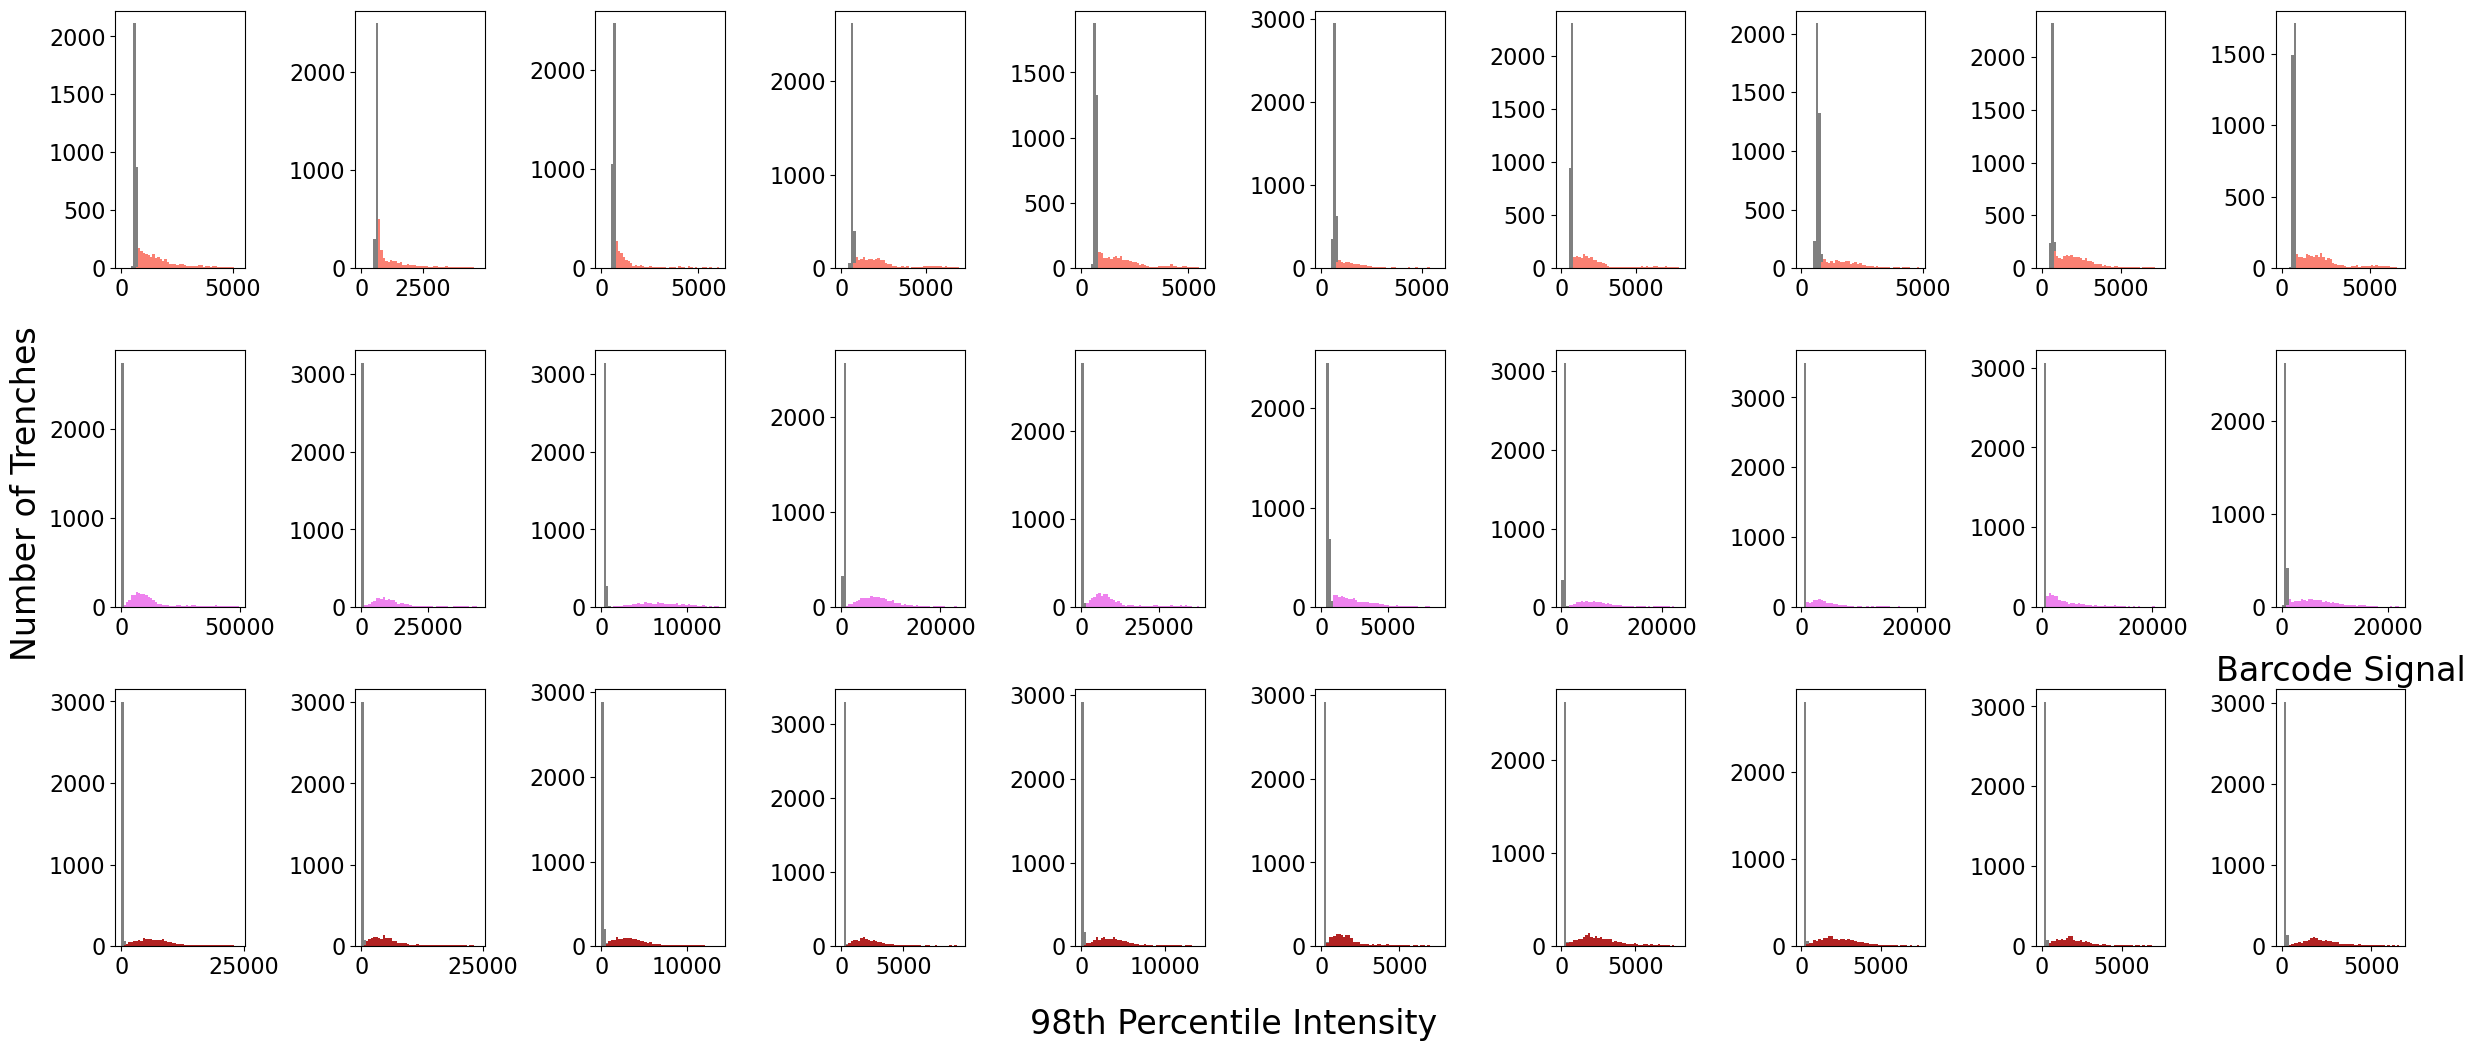

In [83]:
fish_test.export_bit_thresholds()

In [84]:
fish_test.bit_threshold_list

[750,
 700,
 750,
 800,
 800,
 800,
 850,
 850,
 800,
 850,
 1300,
 1300,
 1000,
 1200,
 1200,
 900,
 1200,
 800,
 1000,
 1300,
 800,
 800,
 700,
 500,
 500,
 400,
 400,
 400,
 400,
 400]

In [85]:
fish_test.output_barcode_df(dask_controller,exp_dir+'Barcodes/barcode_output__big_hd2.hdf5')

Getting Barcode df...


/n/scratch/users/n/nao5/251209_experiment/TrenchRipper/trenchripper/marlin.py:767: UserWarning: `meta` is not specified, inferred from partial data.
Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result

  barcodes = trench_group.apply(lambda x: list(itertools.chain.from_iterable([x[channel].tolist()\
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 12.90 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Getting Nanopore df...
Merging...


/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/array/routines.py:452: PerformanceWarning: Increasing number of chunks by factor of 24
  out = blockwise(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/array/routines.py:452: PerformanceWarning: Increasing number of chunks by factor of 24
  out = blockwise(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 29.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nao5/miniconda3/envs/crispri/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 29.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 o

In [86]:
dask_controller.shutdown()

Done.
